414 พงศ์รวิช
422 ศักดิพัฒน์
438 วรดร
449 วัฒนศิริ
450 เสฏฐวุฒิ

In [8]:
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
from finta import TA
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from matplotlib.colors import ListedColormap

# Decision Tree Classifier: Create and Train the model
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
import pandas_datareader as pdr  # ดึงข้อมูลจากที่อื่นได้หมด
import random, warnings
from sklearn.datasets import load_boston

import matplotlib
import seaborn as sns
import statsmodels.api as sm  # pip install statsmodels
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
import talib
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import absolute
from numpy import sqrt

from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import warnings
warnings.filterwarnings('ignore')

In [9]:
pd.options.display.float_format = "{:,.3f}".format
warnings.simplefilter(action='ignore', category=FutureWarning)
random.seed(123)

In [10]:
# download dataframe
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']
INTERVAL = '1d'     # อัตราตัวอย่างข้อมูลย้อนหลัง
symbol = '^HSI'      # สัญลักษณ์ของหุ้น
# start = (datetime.date.today() - datetime.timedelta( NUM_DAYS ) ) #2 ปี
# end = datetime.datetime.today()
data = yf.download(symbol, start='2019-12-04', end='2021-12-04', interval=INTERVAL)

[*********************100%***********************]  1 of 1 completed


In [11]:
def get_indicator(data):
    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)
    data['ema50'] = data['Close'] / data['Close'].ewm(50).mean()
    data['ema21'] = data['Close'] / data['Close'].ewm(21).mean()
    data['ema15'] = data['Close'] / data['Close'].ewm(14).mean()
    data['ema5'] = data['Close'] / data['Close'].ewm(5).mean()
    data['normVol'] = data['Volume'] / data['Volume'].ewm(5).mean()

    # ลบ columns
    del (data['Open'])
    del (data['High'])
    del (data['Low'])
    del (data['Volume'])
    del (data['Adj Close'])
    
    return data

data = get_indicator(data)
print(data.columns)

Index(['Close', '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
       '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV', '20 period CCI',
       '14 period EMV', 'VIm', 'VIp', 'ema50', 'ema21', 'ema15', 'ema5',
       'normVol'],
      dtype='object')


In [12]:
def pred(data,window):
    for i in range(len(data)-window):
        if((abs(data['Close'][i+window] - data['Close'][i])/100) <= 0.5): #0.5% sideway
            data['pred'][i] = 2
        elif(data['Close'][i] <= data['Close'][i+window]):
            data['pred'][i] = 1
        else:
            data['pred'][i] = 0
    return data

data['pred'] = 0
data = pred(data,1)

data = data.fillna(method='bfill') # Some indicators produce NaN values for the first few rows, we just remove them here
data.dropna(inplace=True)
del (data['Close'])
X = data.drop("pred", axis=1)  # Feature Matrix
y = data["pred"] 

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

def feature_selection(X,y):
    # no. of features
    nof_list = np.arange(1, 19)            
    high_score = 0

    # Variable to store the optimum features
    nof = 0           
    score_list = []

    for n in range(len(nof_list)):
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15, random_state = 0)

        model = RandomForestClassifier(random_state=0,n_estimators=200)
        rfe = RFE(model, n_features_to_select=nof_list[n])
        X_train_rfe = rfe.fit_transform(X_train,y_train)
        X_test_rfe = rfe.transform(X_test)
        model.fit(X_train_rfe,y_train)

        score = model.score(X_test_rfe,y_test)
        score_list.append(score)

        if(score > high_score):
            high_score = score
            nof = nof_list[n]

    print("Optimum number of features: %d" % nof)
    print("Score with %d features: %f" % (nof, high_score))
    return (nof)


In [14]:
nof = feature_selection(X,y)

Optimum number of features: 6
Score with 6 features: 0.453333


In [15]:
y = y.astype('int')
cols = list(X.columns)
model = RandomForestClassifier(random_state=0)

# Initializing RFE model
rfe = RFE(model, n_features_to_select=nof)             

# Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  

# Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_, index = cols)
selected_features_rfe = temp[temp==True].index

print(selected_features_rfe)

feats = data[selected_features_rfe] # Feature Matrix
X = feats
y = data["pred"] 

Index(['SIGNAL', 'MFV', 'MOM', 'OBV', 'ema5', 'normVol'], dtype='object')


ROC CURVE

In [16]:
def re_shape(df):
    data = []
    for i in df:
        if(i==0):
            data.append([1,0,0])
        elif(i==1):
            data.append([0,1,0])
        else:
            data.append([0,0,1])
    return data

def plot(y_test,y_pred):
       
    plt.figure(figsize=(12,8))
    model = label_binarize(y_test, classes=[0,1,2])
    n_classes = model.shape[1]
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_test = np.array(re_shape(y_test))
    y_pred = np.array(re_shape(y_pred)) 
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
        colors = cycle(['blue','red','orange'])
    for i,color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=4, label='Roc curve of class {0} (area = {1:0.2f})'''.format(i, roc_auc[i]))
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range (n_classes)]))
    
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        
    mean_tpr /= n_classes
    
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])
 
    plt.plot(fpr["macro"], tpr["macro"], label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),color="green",linestyle=":",linewidth=4)
    plt.plot([0,1], [0,1],linestyle="--",color="black",linewidth=4)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    return (roc_auc["macro"])
    

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.15, random_state=0)

# Feature Scale
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

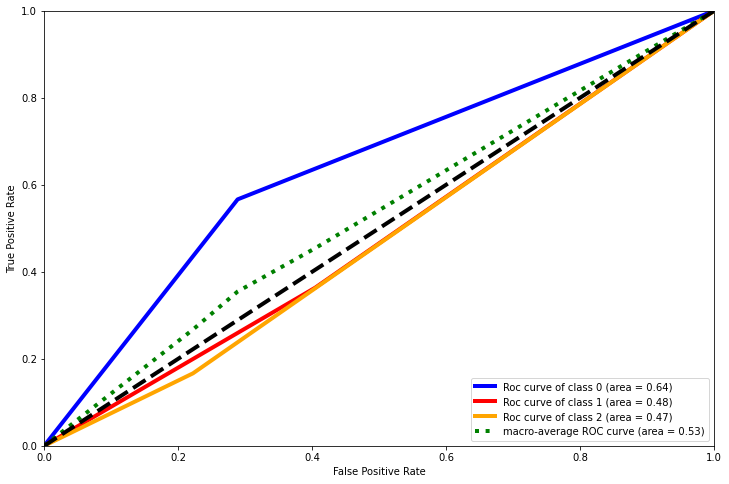

In [18]:
dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(X_train, y_train)
# Prediction
y_pred_dtc = dtc.predict(X_test)  #Accuracy
macro_avg_dtc = plot(y_test,y_pred_dtc)

In [19]:
cv = KFold(n_splits=5, random_state=0,shuffle=True)
lb = LabelBinarizer()
y_train = np.array([number[0] for number in lb.fit_transform(y_train)])

#use k-fold CV to evaluate model
score_acc_dtc = cross_val_score(dtc, X_train, y_train, scoring='accuracy',
                         cv=cv, n_jobs=-1)

score_recall_dtc = cross_val_score(dtc, X_train, y_train, scoring='recall_macro',
                         cv=cv, n_jobs=-1)

score_precision_dtc = cross_val_score(dtc, X_train, y_train, scoring='precision_weighted',
                         cv=cv, n_jobs=-1)

score_f_dtc = cross_val_score(dtc, X_train, y_train, scoring='f1_macro',
                         cv=cv, n_jobs=-1)

RandomForestClassifier

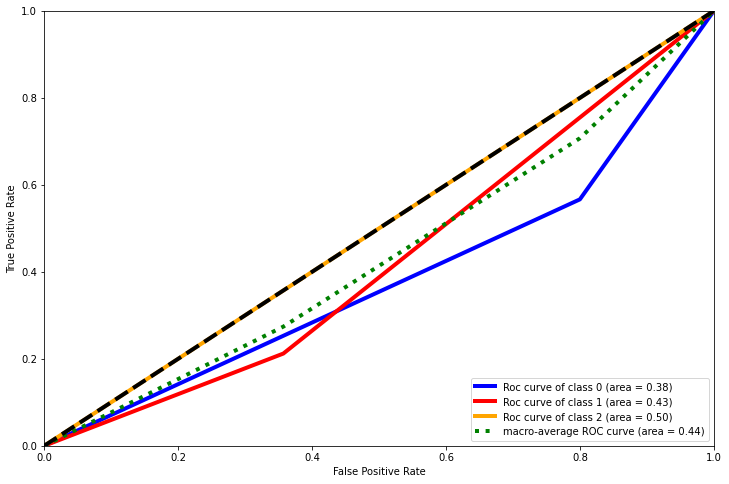

In [20]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)
# Predicting the Test set results
y_pred_rf = rf.predict(X_test)
macro_avg_rf = plot(y_test,y_pred_rf)

In [21]:
cv = KFold(n_splits=5, random_state=0,shuffle=True)
lb = LabelBinarizer()
y_train = np.array([number[0] for number in lb.fit_transform(y_train)])

#use k-fold CV to evaluate model
score_acc_rf = cross_val_score(rf, X_train, y_train, scoring='accuracy',
                         cv=cv, n_jobs=-1)

score_recall_rf = cross_val_score(rf, X_train, y_train, scoring='recall_macro',
                         cv=cv, n_jobs=-1)

score_precision_rf = cross_val_score(rf, X_train, y_train, scoring='precision_weighted',
                         cv=cv, n_jobs=-1)

score_f_rf = cross_val_score(rf, X_train, y_train, scoring='f1_macro',
                         cv=cv, n_jobs=-1)

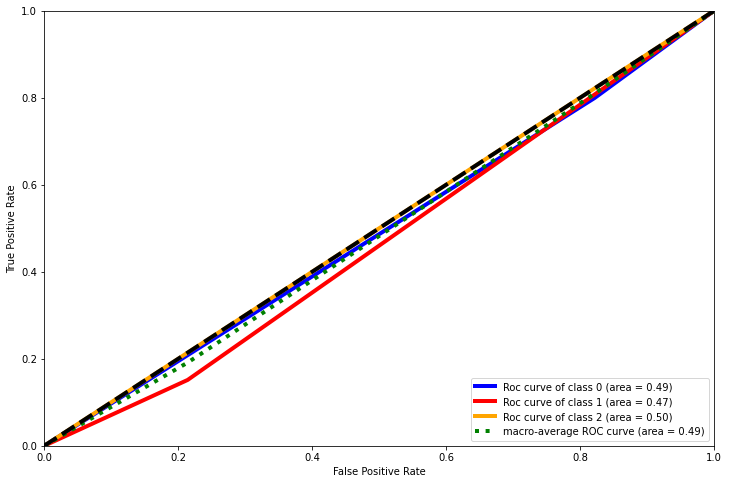

In [22]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=1000, random_state=0)
mlp.fit(X_train, y_train)
# Predicting the Test set results
y_pred_mlp = mlp.predict(X_test)
macro_avg_mlp = plot(y_test,y_pred_mlp)

In [23]:
cv = KFold(n_splits=5, random_state=0,shuffle=True)
lb = LabelBinarizer()
y_train = np.array([number[0] for number in lb.fit_transform(y_train)])

#use k-fold CV to evaluate model
score_acc_mlp = cross_val_score(mlp, X_train, y_train, scoring='accuracy',
                         cv=cv, n_jobs=-1)

score_recall_mlp = cross_val_score(mlp, X_train, y_train, scoring='recall_macro',
                         cv=cv, n_jobs=-1)

score_precision_mlp = cross_val_score(mlp, X_train, y_train, scoring='precision_weighted',
                         cv=cv, n_jobs=-1)

score_f_mlp = cross_val_score(mlp, X_train, y_train, scoring='f1_macro',
                         cv=cv, n_jobs=-1)

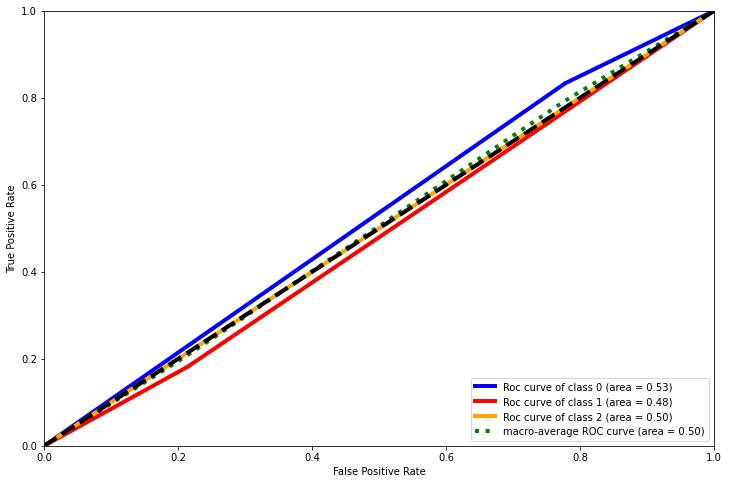

In [24]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

# Create a dictionary of all values we want to test for n_neighbors
params_knn = {'n_neighbors': np.arange(1, 3)}

# Use gridsearch to test all values for n_neighbors
knn_gs = GridSearchCV(knn, params_knn, cv=5)
knn_gs.fit(X_train, y_train)
knn_best = knn_gs.best_estimator_
y_pred_knn = knn_best.predict(X_test)

macro_avg_knn = plot(y_test,y_pred_knn)

In [25]:
cv = KFold(n_splits=5, random_state=0,shuffle=True)
lb = LabelBinarizer()
y_train = np.array([number[0] for number in lb.fit_transform(y_train)])

#use k-fold CV to evaluate model
score_acc_knn = cross_val_score(knn_best, X_train, y_train, scoring='accuracy',
                         cv=cv, n_jobs=-1)

score_recall_knn = cross_val_score(knn_best, X_train, y_train, scoring='recall_macro',
                         cv=cv, n_jobs=-1)

score_precision_knn = cross_val_score(knn_best, X_train, y_train, scoring='precision_weighted',
                         cv=cv, n_jobs=-1)

score_f_knn = cross_val_score(knn_best, X_train, y_train, scoring='f1_macro',
                         cv=cv, n_jobs=-1)


sum of score for each model

In [170]:
print('sum of score in HSI 2 years ago')
print('accuracy')
print('DecisionTree ',np.mean(score_acc_dtc))
print('RandomForest ',np.mean(score_acc_rf))
print('MLP          ',np.mean(score_acc_mlp))
print('KNeighbors   ',np.mean(score_acc_knn))

print('\nrecall')
print('DecisionTree ',np.mean(score_recall_dtc))
print('RandomForest ',np.mean(score_recall_rf))
print('MLP          ',np.mean(score_recall_mlp))
print('KNeighbors   ',np.mean(score_recall_knn))

print('\nprecision')
print('DecisionTree ',np.mean(score_precision_dtc))
print('RandomForest ',np.mean(score_precision_rf))
print('MLP          ',np.mean(score_precision_mlp))
print('KNeighbors   ',np.mean(score_precision_knn))

print('\nf-socre')
print('DecisionTree ',np.mean(score_f_dtc))
print('RandomForest ',np.mean(score_f_rf))
print('MLP          ',np.mean(score_f_mlp))
print('KNeighbors   ',np.mean(score_f_knn))

print('\nROC CURVE macro average ')
print('DecisionTree ',macro_avg_dtc)
print('RandomForest ',macro_avg_rf)
print('MLP          ', macro_avg_mlp)
print('KNeighbors   ',macro_avg_knn)

sum of score in HSI 2 years ago
accuracy
DecisionTree  0.4916236374067699
RandomForest  0.548938611589214
MLP           0.5300057372346528
KNeighbors    0.5727768215720023

recall
DecisionTree  0.4763638308353532
RandomForest  0.5138720853532065
MLP           0.5064140449463566
KNeighbors    0.5158205263273178

precision
DecisionTree  0.4943380725727078
RandomForest  0.5322280275058284
MLP           0.5237596749055198
KNeighbors    0.5431815961759304

f-socre
DecisionTree  0.4735618515051706
RandomForest  0.5062235891422812
MLP           0.5021966880321418
KNeighbors    0.4830226609684603

ROC CURVE macro average 
DecisionTree  0.4801827801827802
RandomForest  0.43694083694083696
MLP           0.48583453583453595
KNeighbors    0.5038480038480038


Comparison of the accuracy

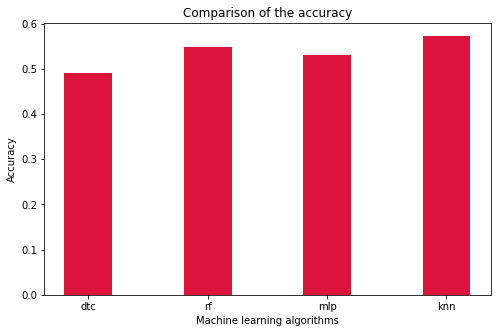

In [42]:
data = {'dtc':np.mean(score_acc_dtc), 'rf':np.mean(score_acc_rf), 'mlp':np.mean(score_acc_mlp),'knn':np.mean(score_acc_knn)}

courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (8, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='crimson',
        width = 0.4)
 
plt.xlabel("Machine learning algorithms")
plt.ylabel("Accuracy")
plt.title("Comparison of the accuracy")
plt.show()

HSI 4 years ago

In [43]:
data = yf.download(symbol, start='2017-12-04', end='2021-12-04', interval=INTERVAL) #4 ปี

[*********************100%***********************]  1 of 1 completed


In [44]:
data = get_indicator(data)
data['pred'] = 0
data = pred(data,1)

data = data.fillna(method='bfill') # Some indicators produce NaN values for the first few rows, we just remove them here
data.dropna(inplace=True)
del (data['Close'])
X = data.drop("pred", axis=1)  # Feature Matrix
y = data["pred"] 

#feature selection
nof = feature_selection(X,y)

y = y.astype('int')
cols = list(X.columns)
model = RandomForestClassifier(random_state=0)
rfe = RFE(model, n_features_to_select=nof)             
X_rfe = rfe.fit_transform(X,y)  
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_, index = cols)
selected_features_rfe = temp[temp==True].index

print(selected_features_rfe)

#data after feature selection
feats = data[selected_features_rfe] # Feature Matrix
X = feats
y = data["pred"] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.15, random_state=0)

# Feature Scale
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Optimum number of features: 5
Score with 5 features: 0.513514
Index(['SIGNAL', 'MFV', 'OBV', 'ema5', 'normVol'], dtype='object')


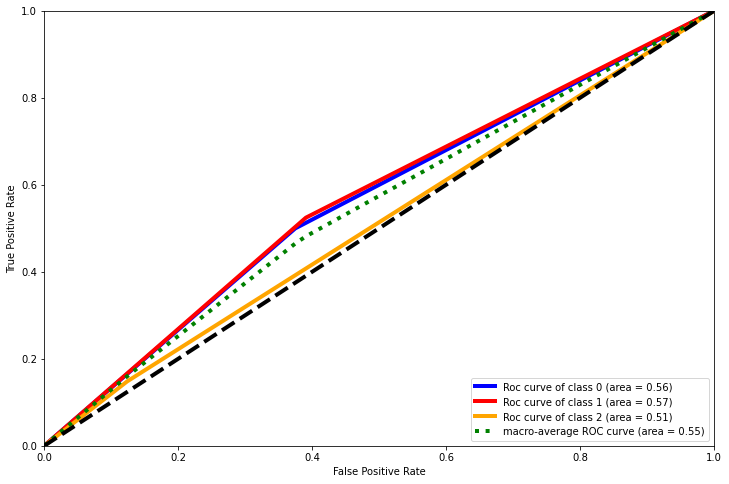

In [45]:
dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(X_train, y_train)

# Prediction 
y_pred = dtc.predict(X_test)  #Accuracy
macro_avg_dtc = plot(y_test,y_pred)

In [46]:
cv = KFold(n_splits=5, random_state=0,shuffle=True)
lb = LabelBinarizer()
y_train = np.array([number[0] for number in lb.fit_transform(y_train)])

#use k-fold CV to evaluate model
score_acc_dtc = cross_val_score(dtc, X_train, y_train, scoring='accuracy',
                         cv=cv, n_jobs=-1)

score_recall_dtc = cross_val_score(dtc, X_train, y_train, scoring='recall_macro',
                         cv=cv, n_jobs=-1)

score_precision_dtc = cross_val_score(dtc, X_train, y_train, scoring='precision_weighted',
                         cv=cv, n_jobs=-1)

score_f_dtc = cross_val_score(dtc, X_train, y_train, scoring='f1_macro',
                         cv=cv, n_jobs=-1)

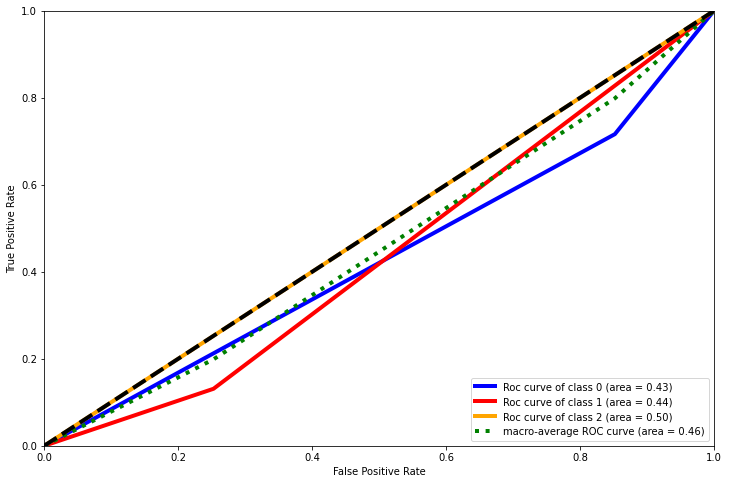

In [47]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)
# Predicting the Test set results
y_pred = rf.predict(X_test)
macro_avg_rf = plot(y_test,y_pred)

In [48]:
cv = KFold(n_splits=5, random_state=0,shuffle=True)
lb = LabelBinarizer()
y_train = np.array([number[0] for number in lb.fit_transform(y_train)])

#use k-fold CV to evaluate model
score_acc_rf = cross_val_score(rf, X_train, y_train, scoring='accuracy',
                         cv=cv, n_jobs=-1)

score_recall_rf = cross_val_score(rf, X_train, y_train, scoring='recall_macro',
                         cv=cv, n_jobs=-1)

score_precision_rf = cross_val_score(rf, X_train, y_train, scoring='precision_weighted',
                         cv=cv, n_jobs=-1)

score_f_rf = cross_val_score(rf, X_train, y_train, scoring='f1_macro',
                         cv=cv, n_jobs=-1)

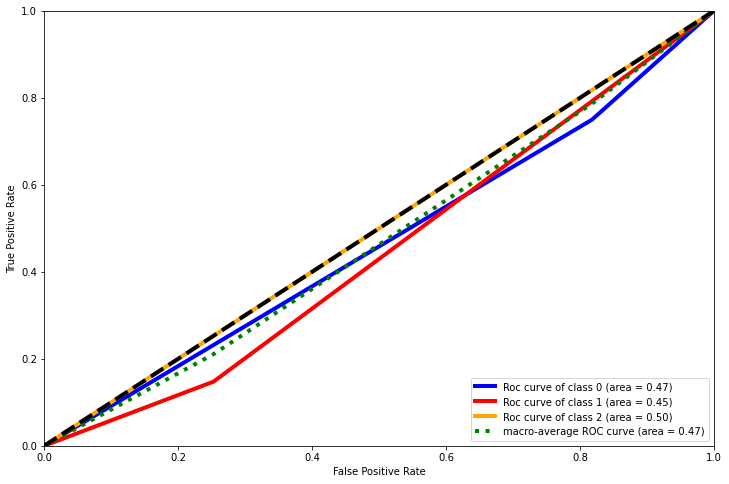

In [49]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=1000, random_state=0)
mlp.fit(X_train, y_train)
# Predicting the Test set results
y_pred = mlp.predict(X_test)
macro_avg_mlp = plot(y_test,y_pred)

In [50]:
cv = KFold(n_splits=5, random_state=0,shuffle=True)
lb = LabelBinarizer()
y_train = np.array([number[0] for number in lb.fit_transform(y_train)])

#use k-fold CV to evaluate model
score_acc_mlp = cross_val_score(mlp, X_train, y_train, scoring='accuracy',
                         cv=cv, n_jobs=-1)

score_recall_mlp = cross_val_score(mlp, X_train, y_train, scoring='recall_macro',
                         cv=cv, n_jobs=-1)

score_precision_mlp = cross_val_score(mlp, X_train, y_train, scoring='precision_weighted',
                         cv=cv, n_jobs=-1)

score_f_mlp = cross_val_score(mlp, X_train, y_train, scoring='f1_macro',
                         cv=cv, n_jobs=-1)

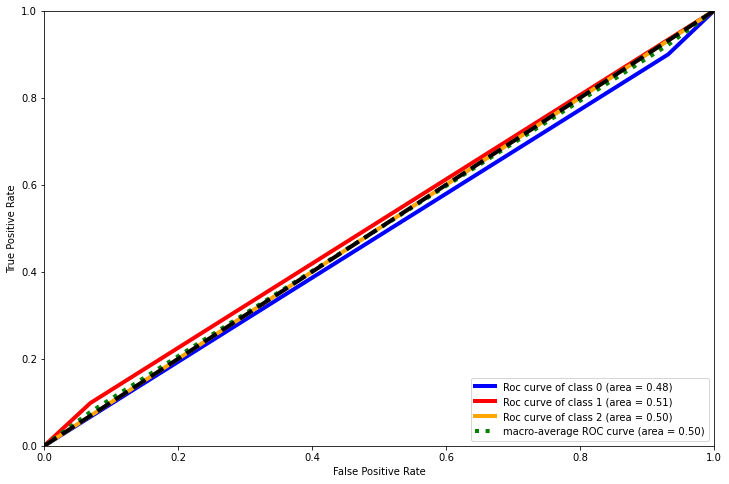

In [51]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

# Create a dictionary of all values we want to test for n_neighbors
params_knn = {'n_neighbors': np.arange(1, 3)}

# Use gridsearch to test all values for n_neighbors
knn_gs = GridSearchCV(knn, params_knn, cv=5)
knn_gs.fit(X_train, y_train)
knn_best = knn_gs.best_estimator_
y_pred = knn_best.predict(X_test)

macro_avg_knn = plot(y_test,y_pred)

In [52]:
cv = KFold(n_splits=5, random_state=0,shuffle=True)
lb = LabelBinarizer()
y_train = np.array([number[0] for number in lb.fit_transform(y_train)])

#use k-fold CV to evaluate model
score_acc_knn = cross_val_score(knn_best, X_train, y_train, scoring='accuracy',
                         cv=cv, n_jobs=-1)

score_recall_knn = cross_val_score(knn_best, X_train, y_train, scoring='recall_macro',
                         cv=cv, n_jobs=-1)

score_precision_knn = cross_val_score(knn_best, X_train, y_train, scoring='precision_weighted',
                         cv=cv, n_jobs=-1)

score_f_knn = cross_val_score(knn_best, X_train, y_train, scoring='f1_macro',
                         cv=cv, n_jobs=-1)

In [53]:
print('sum of score in HSI 4 years ago')
print('accuracy')
print('DecisionTree ',np.mean(score_acc_dtc))
print('RandomForest ',np.mean(score_acc_rf))
print('MLP          ',np.mean(score_acc_mlp))
print('KNeighbors   ',np.mean(score_acc_knn))

print('\nrecall')
print('DecisionTree ',np.mean(score_recall_dtc))
print('RandomForest ',np.mean(score_recall_rf))
print('MLP          ',np.mean(score_recall_mlp))
print('KNeighbors   ',np.mean(score_recall_knn))

print('\nprecision')
print('DecisionTree ',np.mean(score_precision_dtc))
print('RandomForest ',np.mean(score_precision_rf))
print('MLP          ',np.mean(score_precision_mlp))
print('KNeighbors   ',np.mean(score_precision_knn))

print('\nf-socre')
print('DecisionTree ',np.mean(score_f_dtc))
print('RandomForest ',np.mean(score_f_rf))
print('MLP          ',np.mean(score_f_mlp))
print('KNeighbors   ',np.mean(score_f_knn))

print('\nROC CURVE macro average ')
print('DecisionTree ',macro_avg_dtc)
print('RandomForest ',macro_avg_rf)
print('MLP          ', macro_avg_mlp)
print('KNeighbors   ',macro_avg_knn)

sum of score in HSI 4 years ago
accuracy
DecisionTree  0.5238522954091817
RandomForest  0.5823567151411464
MLP           0.5572783005417736
KNeighbors    0.5740091246079271

recall
DecisionTree  0.4988492380187394
RandomForest  0.5363579089407491
MLP           0.5127502198619577
KNeighbors    0.5088274178577492

precision
DecisionTree  0.5212310034375349
RandomForest  0.5623185148083387
MLP           0.53626463068497
KNeighbors    0.5350444399460168

f-socre
DecisionTree  0.49723937311061556
RandomForest  0.5264690152831535
MLP           0.5021079833270166
KNeighbors    0.474165925834053

ROC CURVE macro average 
DecisionTree  0.5471611287054441
RandomForest  0.4571113195265259
MLP           0.4710809337010581
KNeighbors    0.4995961594463573


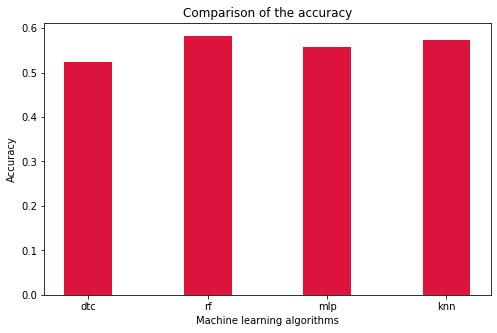

In [54]:
data = {'dtc':np.mean(score_acc_dtc), 'rf':np.mean(score_acc_rf), 'mlp':np.mean(score_acc_mlp),'knn':np.mean(score_acc_knn)}

courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (8, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='crimson',
        width = 0.4)
 
plt.xlabel("Machine learning algorithms")
plt.ylabel("Accuracy")
plt.title("Comparison of the accuracy")
plt.show()

In [55]:
symbol = '^N225'
data = yf.download(symbol, start='2019-12-04', end='2021-12-04', interval=INTERVAL) #2 ปี
data = get_indicator(data)
data['pred'] = 0
data = pred(data,1)
data = data.fillna(method='bfill') # Some indicators produce NaN values for the first few rows, we just remove them here
data.dropna(inplace=True)
del (data['Close'])
X = data.drop("pred", axis=1)  # Feature Matrix
y = data["pred"] 

#feature selection
nof = feature_selection(X,y)

y = y.astype('int')
cols = list(X.columns)
model = RandomForestClassifier(random_state=0)
rfe = RFE(model, n_features_to_select=nof)             
X_rfe = rfe.fit_transform(X,y)  
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_, index = cols)
selected_features_rfe = temp[temp==True].index

print(selected_features_rfe)

#data after feature selection

feats = data[selected_features_rfe] # Feature Matrix
X = feats
y = data["pred"] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.15, random_state=0)

# Feature Scale
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

[*********************100%***********************]  1 of 1 completed
Optimum number of features: 17
Score with 17 features: 0.540541
Index(['14 period RSI', 'SIGNAL', '14 period STOCH %K', 'MFV', '14 period ATR',
       'MOM', '14 period MFI', 'ROC', 'OBV', '20 period CCI', '14 period EMV',
       'VIm', 'VIp', 'ema50', 'ema15', 'ema5', 'normVol'],
      dtype='object')


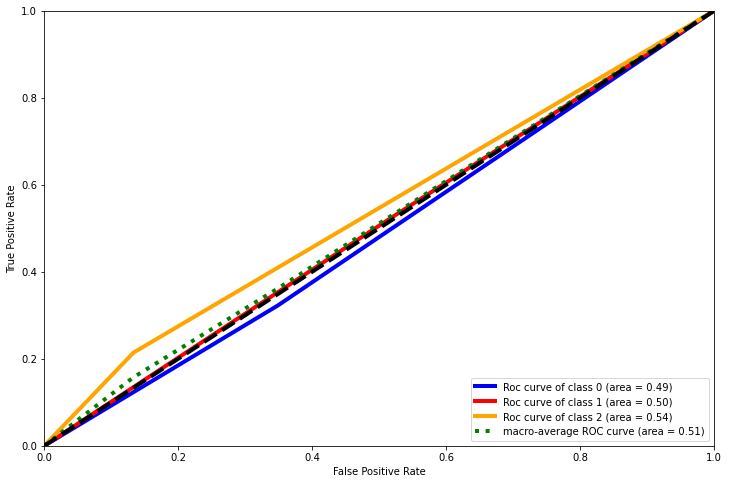

In [56]:
dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(X_train, y_train)

# Prediction
y_pred = dtc.predict(X_test)
macro_avg_dtc = plot(y_test,y_pred)

In [57]:
cv = KFold(n_splits=5, random_state=0,shuffle=True)
lb = LabelBinarizer()
y_train = np.array([number[0] for number in lb.fit_transform(y_train)])

#use k-fold CV to evaluate model
score_acc_dtc = cross_val_score(dtc, X_train, y_train, scoring='accuracy',
                         cv=cv, n_jobs=-1)

score_recall_dtc = cross_val_score(dtc, X_train, y_train, scoring='recall_macro',
                         cv=cv, n_jobs=-1)

score_precision_dtc = cross_val_score(dtc, X_train, y_train, scoring='precision_weighted',
                         cv=cv, n_jobs=-1)

score_f_dtc = cross_val_score(dtc, X_train, y_train, scoring='f1_macro',
                         cv=cv, n_jobs=-1)

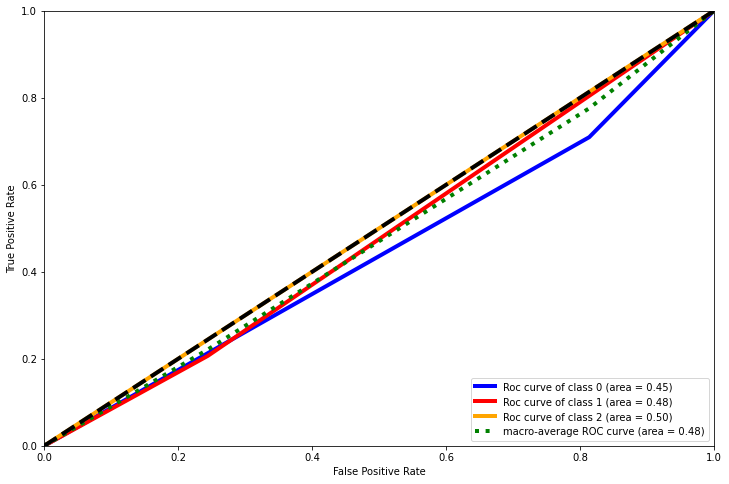

In [58]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)
# Predicting the Test set results
y_pred = rf.predict(X_test)
macro_avg_rf = plot(y_test,y_pred)

In [59]:
cv = KFold(n_splits=5, random_state=0,shuffle=True)
lb = LabelBinarizer()
y_train = np.array([number[0] for number in lb.fit_transform(y_train)])

#use k-fold CV to evaluate model
score_acc_rf = cross_val_score(rf, X_train, y_train, scoring='accuracy',
                         cv=cv, n_jobs=-1)

score_recall_rf = cross_val_score(rf, X_train, y_train, scoring='recall_macro',
                         cv=cv, n_jobs=-1)

score_precision_rf = cross_val_score(rf, X_train, y_train, scoring='precision_weighted',
                         cv=cv, n_jobs=-1)

score_f_rf = cross_val_score(rf, X_train, y_train, scoring='f1_macro',
                         cv=cv, n_jobs=-1)

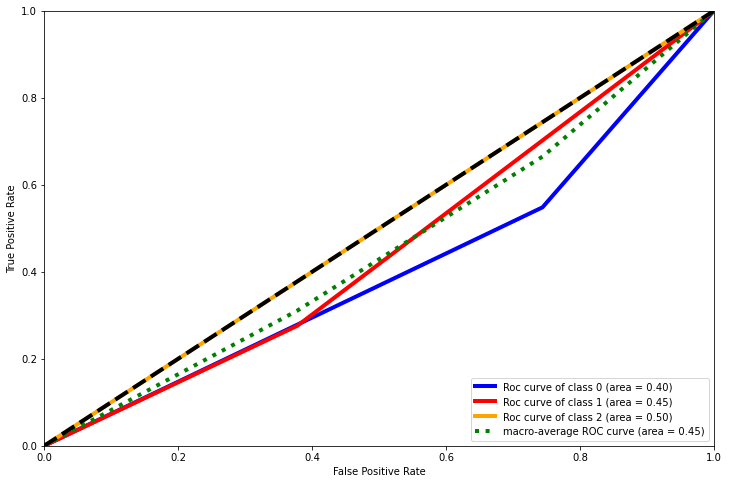

In [60]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=1000, random_state=0)
mlp.fit(X_train, y_train)
# Predicting the Test set results
y_pred = mlp.predict(X_test)
macro_avg_mlp = plot(y_test,y_pred)

In [61]:
cv = KFold(n_splits=5, random_state=0,shuffle=True)
lb = LabelBinarizer()
y_train = np.array([number[0] for number in lb.fit_transform(y_train)])

#use k-fold CV to evaluate model
score_acc_mlp = cross_val_score(mlp, X_train, y_train, scoring='accuracy',
                         cv=cv, n_jobs=-1)

score_recall_mlp = cross_val_score(mlp, X_train, y_train, scoring='recall_macro',
                         cv=cv, n_jobs=-1)

score_precision_mlp = cross_val_score(mlp, X_train, y_train, scoring='precision_weighted',
                         cv=cv, n_jobs=-1)

score_f_mlp = cross_val_score(mlp, X_train, y_train, scoring='f1_macro',
                         cv=cv, n_jobs=-1)

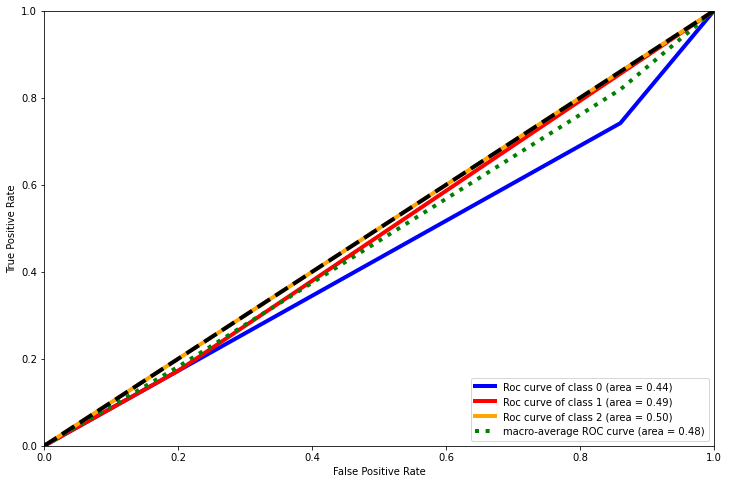

In [62]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

# Create a dictionary of all values we want to test for n_neighbors
params_knn = {'n_neighbors': np.arange(1, 3)}

# Use gridsearch to test all values for n_neighbors
knn_gs = GridSearchCV(knn, params_knn, cv=5)
knn_gs.fit(X_train, y_train)
knn_best = knn_gs.best_estimator_
y_pred = knn_best.predict(X_test)

macro_avg_knn = plot(y_test,y_pred)

In [63]:
cv = KFold(n_splits=5, random_state=0,shuffle=True)
lb = LabelBinarizer()
y_train = np.array([number[0] for number in lb.fit_transform(y_train)])

#use k-fold CV to evaluate model
score_acc_knn = cross_val_score(knn_best, X_train, y_train, scoring='accuracy',
                         cv=cv, n_jobs=-1)

score_recall_knn = cross_val_score(knn_best, X_train, y_train, scoring='recall_macro',
                         cv=cv, n_jobs=-1)

score_precision_knn = cross_val_score(knn_best, X_train, y_train, scoring='precision_weighted',
                         cv=cv, n_jobs=-1)

score_f_knn = cross_val_score(knn_best, X_train, y_train, scoring='f1_macro',
                         cv=cv, n_jobs=-1)

In [64]:
print('sum of score in N225 2 years ago')
print('accuracy')
print('DecisionTree ',np.mean(score_acc_dtc))
print('RandomForest ',np.mean(score_acc_rf))
print('MLP          ',np.mean(score_acc_mlp))
print('KNeighbors   ',np.mean(score_acc_knn))

print('\nrecall')
print('DecisionTree ',np.mean(score_recall_dtc))
print('RandomForest ',np.mean(score_recall_rf))
print('MLP          ',np.mean(score_recall_mlp))
print('KNeighbors   ',np.mean(score_recall_knn))

print('\nprecision')
print('DecisionTree ',np.mean(score_precision_dtc))
print('RandomForest ',np.mean(score_precision_rf))
print('MLP          ',np.mean(score_precision_mlp))
print('KNeighbors   ',np.mean(score_precision_knn))

print('\nf-socre')
print('DecisionTree ',np.mean(score_f_dtc))
print('RandomForest ',np.mean(score_f_rf))
print('MLP          ',np.mean(score_f_mlp))
print('KNeighbors   ',np.mean(score_f_knn))

print('\nROC CURVE macro average ')
print('DecisionTree ',macro_avg_dtc)
print('RandomForest ',macro_avg_rf)
print('MLP          ', macro_avg_mlp)
print('KNeighbors   ',macro_avg_knn)

sum of score in N225 2 years ago
accuracy
DecisionTree  0.5158389656185719
RandomForest  0.49876579488686446
MLP           0.5644137525712607
KNeighbors    0.5447840141052013

recall
DecisionTree  0.4945308675606623
RandomForest  0.4591539284358623
MLP           0.5451244780282695
KNeighbors    0.4864653554550432

precision
DecisionTree  0.5152671625521267
RandomForest  0.47074191591373377
MLP           0.5626494232659388
KNeighbors    0.5002349448880952

f-socre
DecisionTree  0.4919865809448732
RandomForest  0.44388546032235754
MLP           0.5430893538814108
KNeighbors    0.4511964718130148

ROC CURVE macro average 
DecisionTree  0.5101376808350966
RandomForest  0.47636267304373986
MLP           0.4503808902417175
KNeighbors    0.47564736011589104


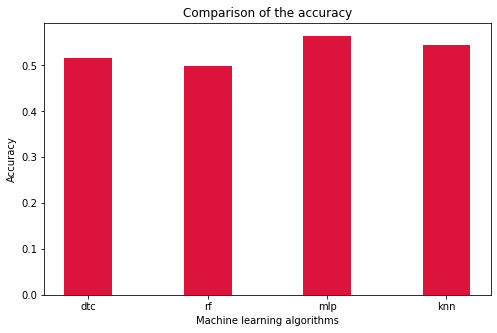

In [65]:
data = {'dtc':np.mean(score_acc_dtc), 'rf':np.mean(score_acc_rf), 'mlp':np.mean(score_acc_mlp),'knn':np.mean(score_acc_knn)}

courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (8, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='crimson',
        width = 0.4)
 
plt.xlabel("Machine learning algorithms")
plt.ylabel("Accuracy")
plt.title("Comparison of the accuracy")
plt.show()

N225 4 years ago

In [66]:
data = yf.download(symbol, start='2017-12-04', end='2021-12-04', interval=INTERVAL) #4 ปี
data = get_indicator(data)
data['pred'] = 0
data = pred(data,1)

data = data.fillna(method='bfill') # Some indicators produce NaN values for the first few rows, we just remove them here
data.dropna(inplace=True)
del (data['Close'])
X = data.drop("pred", axis=1)  # Feature Matrix
y = data["pred"] 

#feature selection
nof = feature_selection(X,y)

y = y.astype('int')
cols = list(X.columns)
model = RandomForestClassifier(random_state=0)
rfe = RFE(model, n_features_to_select=nof)             
X_rfe = rfe.fit_transform(X,y)  
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_, index = cols)
selected_features_rfe = temp[temp==True].index

print(selected_features_rfe)

#data after feature selection

feats = data[selected_features_rfe] # Feature Matrix
X = feats
y = data["pred"] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.15, random_state=0)

# Feature Scale
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

[*********************100%***********************]  1 of 1 completed
Optimum number of features: 14
Score with 14 features: 0.435374
Index(['14 period RSI', 'SIGNAL', '14 period STOCH %K', 'MFV', '14 period ATR',
       'ROC', 'OBV', '20 period CCI', '14 period EMV', 'VIm', 'VIp', 'ema50',
       'ema5', 'normVol'],
      dtype='object')


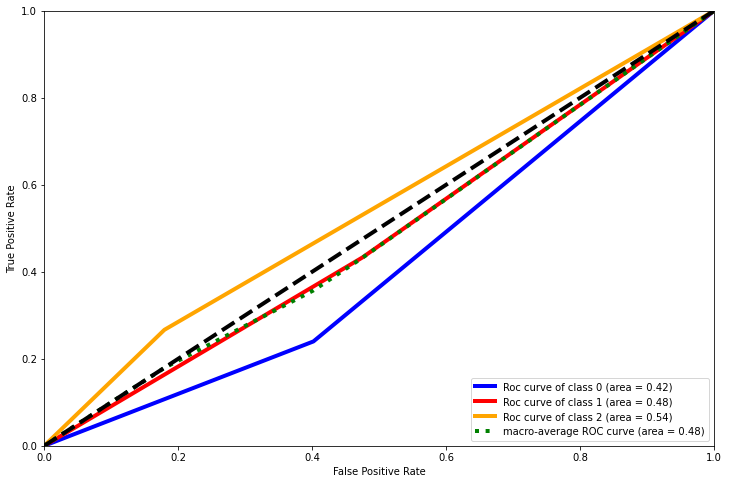

In [67]:
dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(X_train, y_train)

# Prediction
y_pred = dtc.predict(X_test)
macro_avg_dtc = plot(y_test,y_pred)

In [68]:
cv = KFold(n_splits=5, random_state=0,shuffle=True)
lb = LabelBinarizer()
y_train = np.array([number[0] for number in lb.fit_transform(y_train)])

#use k-fold CV to evaluate model
score_acc_dtc = cross_val_score(dtc, X_train, y_train, scoring='accuracy',
                         cv=cv, n_jobs=-1)

score_recall_dtc = cross_val_score(dtc, X_train, y_train, scoring='recall_macro',
                         cv=cv, n_jobs=-1)

score_precision_dtc = cross_val_score(dtc, X_train, y_train, scoring='precision_weighted',
                         cv=cv, n_jobs=-1)

score_f_dtc = cross_val_score(dtc, X_train, y_train, scoring='f1_macro',
                         cv=cv, n_jobs=-1)

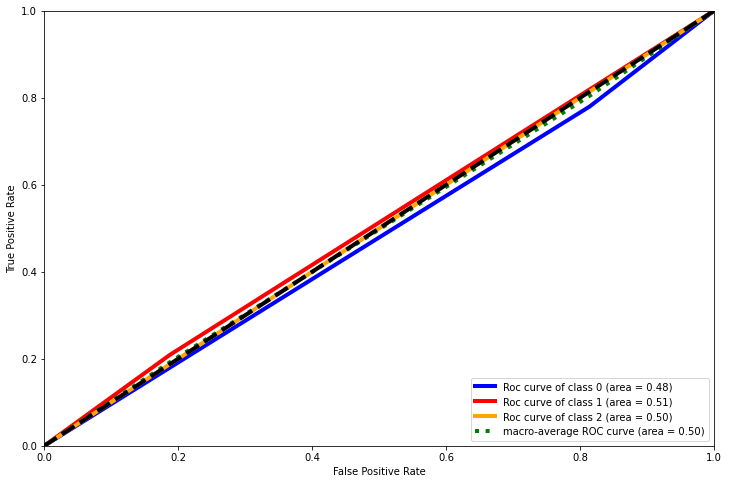

In [69]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)
# Predicting the Test set results
y_pred = rf.predict(X_test)
macro_avg_rf = plot(y_test,y_pred)

In [70]:
cv = KFold(n_splits=5, random_state=0,shuffle=True)
lb = LabelBinarizer()
y_train = np.array([number[0] for number in lb.fit_transform(y_train)])

#use k-fold CV to evaluate model
score_acc_rf = cross_val_score(rf, X_train, y_train, scoring='accuracy',
                         cv=cv, n_jobs=-1)

score_recall_rf = cross_val_score(rf, X_train, y_train, scoring='recall_macro',
                         cv=cv, n_jobs=-1)

score_precision_rf = cross_val_score(rf, X_train, y_train, scoring='precision_weighted',
                         cv=cv, n_jobs=-1)

score_f_rf = cross_val_score(rf, X_train, y_train, scoring='f1_macro',
                         cv=cv, n_jobs=-1)

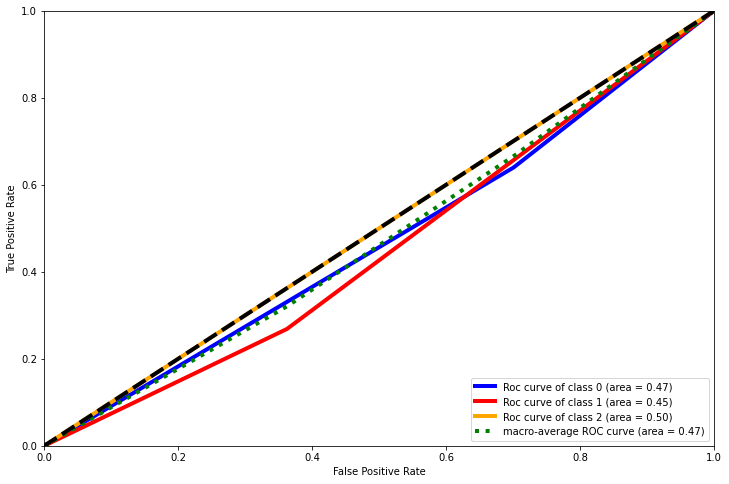

In [71]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=1000, random_state=0)
mlp.fit(X_train, y_train)
# Predicting the Test set results
y_pred = mlp.predict(X_test)
macro_avg_mlp = plot(y_test,y_pred)

In [72]:
cv = KFold(n_splits=5, random_state=0,shuffle=True)
lb = LabelBinarizer()
y_train = np.array([number[0] for number in lb.fit_transform(y_train)])

#use k-fold CV to evaluate model
score_acc_mlp = cross_val_score(mlp, X_train, y_train, scoring='accuracy',
                         cv=cv, n_jobs=-1)

score_recall_mlp = cross_val_score(mlp, X_train, y_train, scoring='recall_macro',
                         cv=cv, n_jobs=-1)

score_precision_mlp = cross_val_score(mlp, X_train, y_train, scoring='precision_weighted',
                         cv=cv, n_jobs=-1)

score_f_mlp = cross_val_score(mlp, X_train, y_train, scoring='f1_macro',
                         cv=cv, n_jobs=-1)

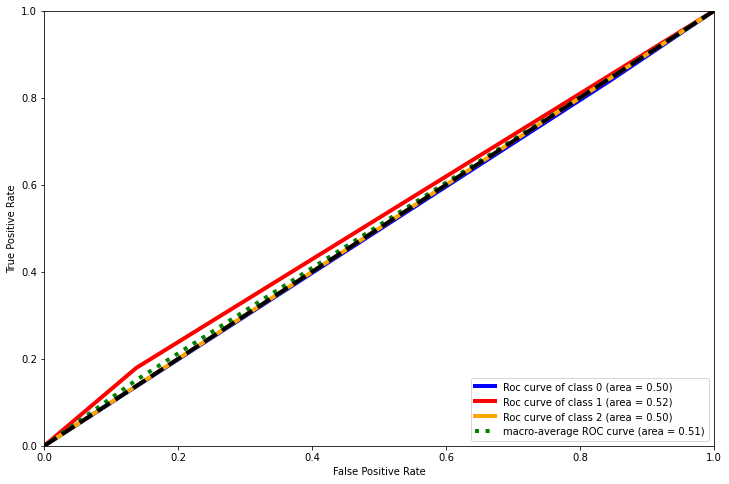

In [73]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

# Create a dictionary of all values we want to test for n_neighbors
params_knn = {'n_neighbors': np.arange(1, 3)}

# Use gridsearch to test all values for n_neighbors
knn_gs = GridSearchCV(knn, params_knn, cv=5)
knn_gs.fit(X_train, y_train)
knn_best = knn_gs.best_estimator_
y_pred = knn_best.predict(X_test)

macro_avg_knn = plot(y_test,y_pred)

In [74]:
cv = KFold(n_splits=5, random_state=0,shuffle=True)
lb = LabelBinarizer()
y_train = np.array([number[0] for number in lb.fit_transform(y_train)])

#use k-fold CV to evaluate model
score_acc_knn = cross_val_score(knn_best, X_train, y_train, scoring='accuracy',
                         cv=cv, n_jobs=-1)

score_recall_knn = cross_val_score(knn_best, X_train, y_train, scoring='recall_macro',
                         cv=cv, n_jobs=-1)

score_precision_knn = cross_val_score(knn_best, X_train, y_train, scoring='precision_weighted',
                         cv=cv, n_jobs=-1)

score_f_knn = cross_val_score(knn_best, X_train, y_train, scoring='f1_macro',
                         cv=cv, n_jobs=-1)

In [75]:
print('sum of score in N225 4 years ago')
print('accuracy')
print('DecisionTree ',np.mean(score_acc_dtc))
print('RandomForest ',np.mean(score_acc_rf))
print('MLP          ',np.mean(score_acc_mlp))
print('KNeighbors   ',np.mean(score_acc_knn))

print('\nrecall')
print('DecisionTree ',np.mean(score_recall_dtc))
print('RandomForest ',np.mean(score_recall_rf))
print('MLP          ',np.mean(score_recall_mlp))
print('KNeighbors   ',np.mean(score_recall_knn))

print('\nprecision')
print('DecisionTree ',np.mean(score_precision_dtc))
print('RandomForest ',np.mean(score_precision_rf))
print('MLP          ',np.mean(score_precision_mlp))
print('KNeighbors   ',np.mean(score_precision_knn))

print('\nf-socre')
print('DecisionTree ',np.mean(score_f_dtc))
print('RandomForest ',np.mean(score_f_rf))
print('MLP          ',np.mean(score_f_mlp))
print('KNeighbors   ',np.mean(score_f_knn))

print('\nROC CURVE macro average ')
print('DecisionTree ',macro_avg_dtc)
print('RandomForest ',macro_avg_rf)
print('MLP          ', macro_avg_mlp)
print('KNeighbors   ',macro_avg_knn)

sum of score in N225 4 years ago
accuracy
DecisionTree  0.5156991602774734
RandomForest  0.5434392113910187
MLP           0.5168747718145308
KNeighbors    0.5761007667031763

recall
DecisionTree  0.5039433138592075
RandomForest  0.4954241039808697
MLP           0.4896344725760442
KNeighbors    0.5051086250049543

precision
DecisionTree  0.5265769464066052
RandomForest  0.5181005483912845
MLP           0.5125636371176224
KNeighbors    0.5274182365295337

f-socre
DecisionTree  0.501338543458908
RandomForest  0.4853478979808491
MLP           0.48808418863845926
KNeighbors    0.46699458844021163

ROC CURVE macro average 
DecisionTree  0.4804922420674844
RandomForest  0.4978370390316459
MLP           0.4741876314304765
KNeighbors    0.5060406088116121


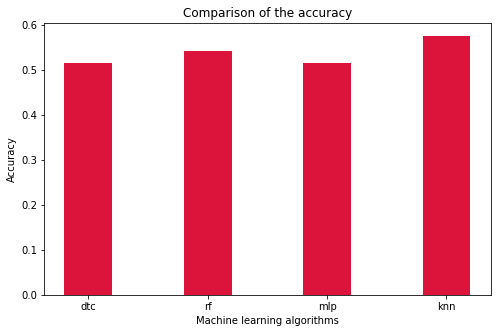

In [76]:
data = {'dtc':np.mean(score_acc_dtc), 'rf':np.mean(score_acc_rf), 'mlp':np.mean(score_acc_mlp),'knn':np.mean(score_acc_knn)}

courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (8, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='crimson',
        width = 0.4)
 
plt.xlabel("Machine learning algorithms")
plt.ylabel("Accuracy")
plt.title("Comparison of the accuracy")
plt.show()

DJI 2 years ago

In [77]:
symbol = '^DJI'
data = yf.download(symbol, start='2019-12-04', end='2021-12-04', interval=INTERVAL) #2 ปี
data = get_indicator(data)
data['pred'] = 0
data = pred(data,1)

data = data.fillna(method='bfill') # Some indicators produce NaN values for the first few rows, we just remove them here
data.dropna(inplace=True)
del (data['Close'])
X = data.drop("pred", axis=1)  # Feature Matrix
y = data["pred"] 

#feature selection
nof = feature_selection(X,y)

y = y.astype('int')
cols = list(X.columns)
model = RandomForestClassifier(random_state=0)
rfe = RFE(model, n_features_to_select=nof)             
X_rfe = rfe.fit_transform(X,y)  
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_, index = cols)
selected_features_rfe = temp[temp==True].index

print(selected_features_rfe)

#data after feature selection

feats = data[selected_features_rfe] # Feature Matrix
X = feats
y = data["pred"] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.15, random_state=0)
# Feature Scale
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


[*********************100%***********************]  1 of 1 completed
Optimum number of features: 7
Score with 7 features: 0.526316
Index(['14 period STOCH %K', 'MFV', '14 period MFI', 'VIm', 'ema50', 'ema5',
       'normVol'],
      dtype='object')


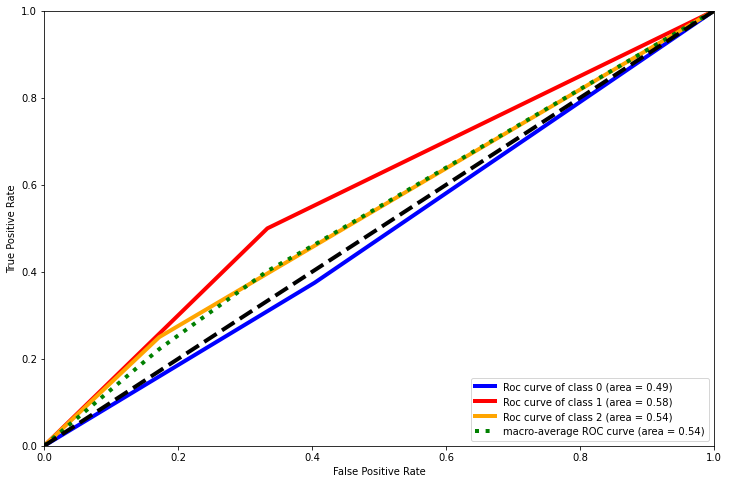

In [78]:
dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(X_train, y_train)

# Prediction
y_pred = dtc.predict(X_test)
macro_avg_dtc = plot(y_test,y_pred)

In [79]:
cv = KFold(n_splits=5, random_state=0,shuffle=True)
lb = LabelBinarizer()
y_train = np.array([number[0] for number in lb.fit_transform(y_train)])

#use k-fold CV to evaluate model
score_acc_dtc = cross_val_score(dtc, X_train, y_train, scoring='accuracy',
                         cv=cv, n_jobs=-1)

score_recall_dtc = cross_val_score(dtc, X_train, y_train, scoring='recall_macro',
                         cv=cv, n_jobs=-1)

score_precision_dtc = cross_val_score(dtc, X_train, y_train, scoring='precision_weighted',
                         cv=cv, n_jobs=-1)

score_f_dtc = cross_val_score(dtc, X_train, y_train, scoring='f1_macro',
                         cv=cv, n_jobs=-1)

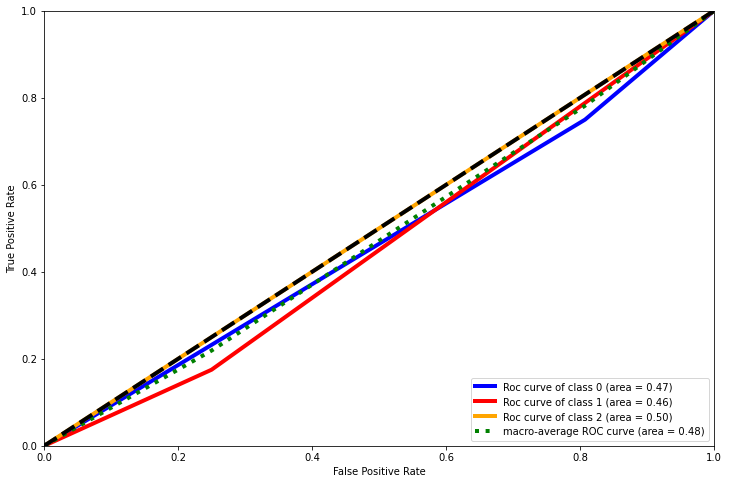

In [80]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)
# Predicting the Test set results
y_pred = rf.predict(X_test)
macro_avg_rf = plot(y_test,y_pred)

In [81]:
cv = KFold(n_splits=5, random_state=0,shuffle=True)
lb = LabelBinarizer()
y_train = np.array([number[0] for number in lb.fit_transform(y_train)])

#use k-fold CV to evaluate model
score_acc_rf = cross_val_score(rf, X_train, y_train, scoring='accuracy',
                         cv=cv, n_jobs=-1)

score_recall_rf = cross_val_score(rf, X_train, y_train, scoring='recall_macro',
                         cv=cv, n_jobs=-1)

score_precision_rf = cross_val_score(rf, X_train, y_train, scoring='precision_weighted',
                         cv=cv, n_jobs=-1)

score_f_rf = cross_val_score(rf, X_train, y_train, scoring='f1_macro',
                         cv=cv, n_jobs=-1)

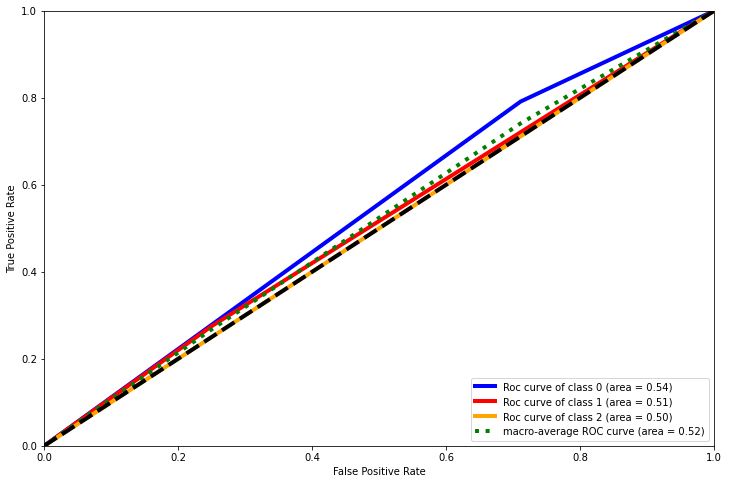

In [82]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=1000, random_state=0)
mlp.fit(X_train, y_train)
# Predicting the Test set results
y_pred = mlp.predict(X_test)
macro_avg_mlp = plot(y_test,y_pred)

In [83]:
cv = KFold(n_splits=5, random_state=0,shuffle=True)
lb = LabelBinarizer()
y_train = np.array([number[0] for number in lb.fit_transform(y_train)])

#use k-fold CV to evaluate model
score_acc_mlp = cross_val_score(mlp, X_train, y_train, scoring='accuracy',
                         cv=cv, n_jobs=-1)

score_recall_mlp = cross_val_score(mlp, X_train, y_train, scoring='recall_macro',
                         cv=cv, n_jobs=-1)

score_precision_mlp = cross_val_score(mlp, X_train, y_train, scoring='precision_weighted',
                         cv=cv, n_jobs=-1)

score_f_mlp = cross_val_score(mlp, X_train, y_train, scoring='f1_macro',
                         cv=cv, n_jobs=-1)

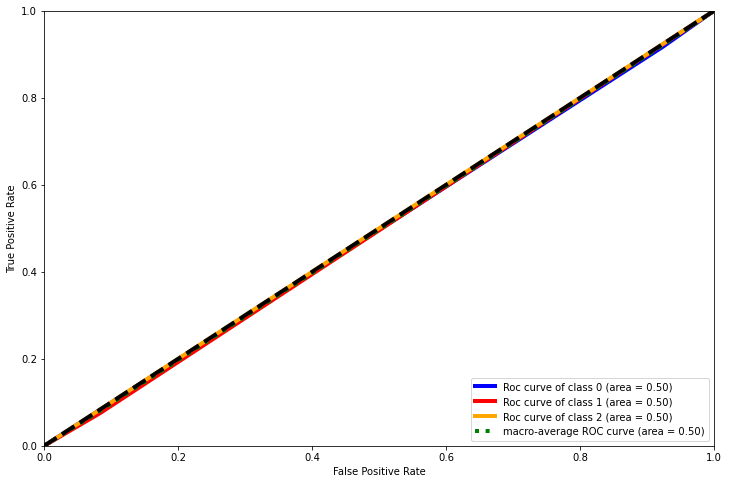

In [84]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

# Create a dictionary of all values we want to test for n_neighbors
params_knn = {'n_neighbors': np.arange(1, 3)}

# Use gridsearch to test all values for n_neighbors
knn_gs = GridSearchCV(knn, params_knn, cv=5)
knn_gs.fit(X_train, y_train)
knn_best = knn_gs.best_estimator_
y_pred = knn_best.predict(X_test)

macro_avg_knn = plot(y_test,y_pred)

In [85]:
cv = KFold(n_splits=5, random_state=0,shuffle=True)
lb = LabelBinarizer()
y_train = np.array([number[0] for number in lb.fit_transform(y_train)])

#use k-fold CV to evaluate model
score_acc_knn = cross_val_score(knn_best, X_train, y_train, scoring='accuracy',
                         cv=cv, n_jobs=-1)

score_recall_knn = cross_val_score(knn_best, X_train, y_train, scoring='recall_macro',
                         cv=cv, n_jobs=-1)

score_precision_knn = cross_val_score(knn_best, X_train, y_train, scoring='precision_weighted',
                         cv=cv, n_jobs=-1)

score_f_knn = cross_val_score(knn_best, X_train, y_train, scoring='f1_macro',
                         cv=cv, n_jobs=-1)

In [86]:
print('sum of score in DJI 2 years ago')
print('accuracy')
print('DecisionTree ',np.mean(score_acc_dtc))
print('RandomForest ',np.mean(score_acc_rf))
print('MLP          ',np.mean(score_acc_mlp))
print('KNeighbors   ',np.mean(score_acc_knn))

print('\nrecall')
print('DecisionTree ',np.mean(score_recall_dtc))
print('RandomForest ',np.mean(score_recall_rf))
print('MLP          ',np.mean(score_recall_mlp))
print('KNeighbors   ',np.mean(score_recall_knn))

print('\nprecision')
print('DecisionTree ',np.mean(score_precision_dtc))
print('RandomForest ',np.mean(score_precision_rf))
print('MLP          ',np.mean(score_precision_mlp))
print('KNeighbors   ',np.mean(score_precision_knn))

print('\nf-socre')
print('DecisionTree ',np.mean(score_f_dtc))
print('RandomForest ',np.mean(score_f_rf))
print('MLP          ',np.mean(score_f_mlp))
print('KNeighbors   ',np.mean(score_f_knn))

print('\nROC CURVE macro average ')
print('DecisionTree ',macro_avg_dtc)
print('RandomForest ',macro_avg_rf)
print('MLP          ', macro_avg_mlp)
print('KNeighbors   ',macro_avg_knn)

sum of score in DJI 2 years ago
accuracy
DecisionTree  0.6232558139534883
RandomForest  0.6116279069767442
MLP           0.6139534883720931
KNeighbors    0.6209302325581396

recall
DecisionTree  0.6041183807126794
RandomForest  0.5574662958921238
MLP           0.5733868824895237
KNeighbors    0.5439924034071301

precision
DecisionTree  0.6362338515806214
RandomForest  0.5985795196477207
MLP           0.609756964738063
KNeighbors    0.5932705999221571

f-socre
DecisionTree  0.5978292880329903
RandomForest  0.546719676902889
MLP           0.5619577236102338
KNeighbors    0.4995708086356957

ROC CURVE macro average 
DecisionTree  0.5359909188034189
RandomForest  0.47788461538461535
MLP           0.5175213675213675
KNeighbors    0.49754273504273494


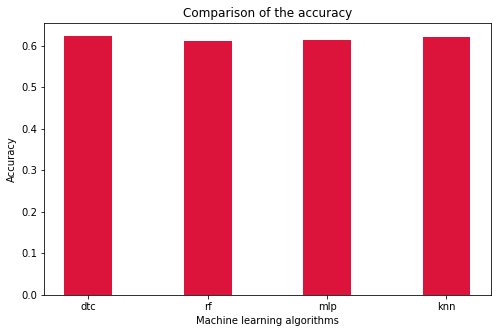

In [87]:
data = {'dtc':np.mean(score_acc_dtc), 'rf':np.mean(score_acc_rf), 'mlp':np.mean(score_acc_mlp),'knn':np.mean(score_acc_knn)}

courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (8, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='crimson',
        width = 0.4)
 
plt.xlabel("Machine learning algorithms")
plt.ylabel("Accuracy")
plt.title("Comparison of the accuracy")
plt.show()

DJI 4 years ago

In [88]:
data = yf.download(symbol, start='2017-12-04', end='2021-12-04', interval=INTERVAL) #4 ปี
data = get_indicator(data)

[*********************100%***********************]  1 of 1 completed


In [89]:
data['pred'] = 0
data = pred(data,1)

data = data.fillna(method='bfill') # Some indicators produce NaN values for the first few rows, we just remove them here
data.dropna(inplace=True)
del (data['Close'])
X = data.drop("pred", axis=1)  # Feature Matrix
y = data["pred"] 

#feature selection
nof = feature_selection(X,y)

y = y.astype('int')
cols = list(X.columns)
model = RandomForestClassifier(random_state=0)
rfe = RFE(model, n_features_to_select=nof)             
X_rfe = rfe.fit_transform(X,y)  
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_, index = cols)
selected_features_rfe = temp[temp==True].index

print(selected_features_rfe)

#data after feature selection
feats = data[selected_features_rfe] # Feature Matrix
X = feats
y = data["pred"] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.15, random_state=0)

# Feature Scale
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


Optimum number of features: 14
Score with 14 features: 0.500000
Index(['MACD', '14 period STOCH %K', 'MFV', '14 period ATR', 'MOM',
       '14 period MFI', 'ROC', 'OBV', 'VIm', 'VIp', 'ema50', 'ema15', 'ema5',
       'normVol'],
      dtype='object')


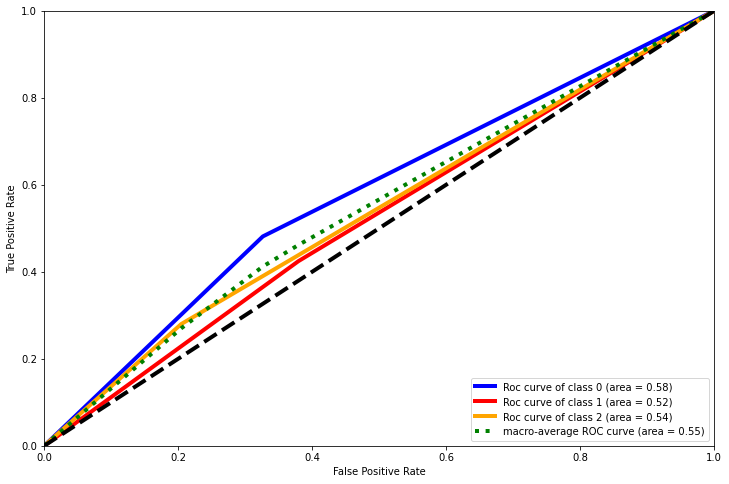

In [90]:
dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(X_train, y_train)

# Prediction
y_pred = dtc.predict(X_test)
macro_avg_dtc = plot(y_test,y_pred)

In [91]:
cv = KFold(n_splits=5, random_state=0,shuffle=True)
lb = LabelBinarizer()
y_train = np.array([number[0] for number in lb.fit_transform(y_train)])

#use k-fold CV to evaluate model
score_acc_dtc = cross_val_score(dtc, X_train, y_train, scoring='accuracy',
                         cv=cv, n_jobs=-1)

score_recall_dtc = cross_val_score(dtc, X_train, y_train, scoring='recall_macro',
                         cv=cv, n_jobs=-1)

score_precision_dtc = cross_val_score(dtc, X_train, y_train, scoring='precision_weighted',
                         cv=cv, n_jobs=-1)

score_f_dtc = cross_val_score(dtc, X_train, y_train, scoring='f1_macro',
                         cv=cv, n_jobs=-1)

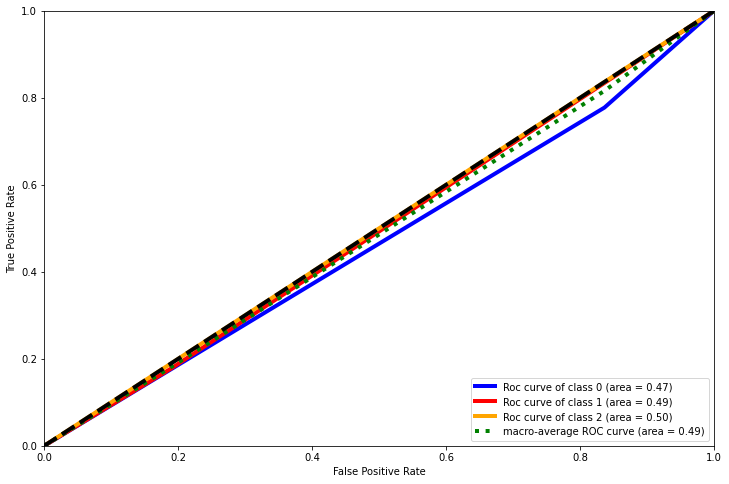

In [92]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)
# Predicting the Test set results
y_pred = rf.predict(X_test)
macro_avg_rf = plot(y_test,y_pred)

In [93]:
cv = KFold(n_splits=5, random_state=0,shuffle=True)
lb = LabelBinarizer()
y_train = np.array([number[0] for number in lb.fit_transform(y_train)])

#use k-fold CV to evaluate model
score_acc_rf = cross_val_score(rf, X_train, y_train, scoring='accuracy',
                         cv=cv, n_jobs=-1)

score_recall_rf = cross_val_score(rf, X_train, y_train, scoring='recall_macro',
                         cv=cv, n_jobs=-1)

score_precision_rf = cross_val_score(rf, X_train, y_train, scoring='precision_weighted',
                         cv=cv, n_jobs=-1)

score_f_rf = cross_val_score(rf, X_train, y_train, scoring='f1_macro',
                         cv=cv, n_jobs=-1)

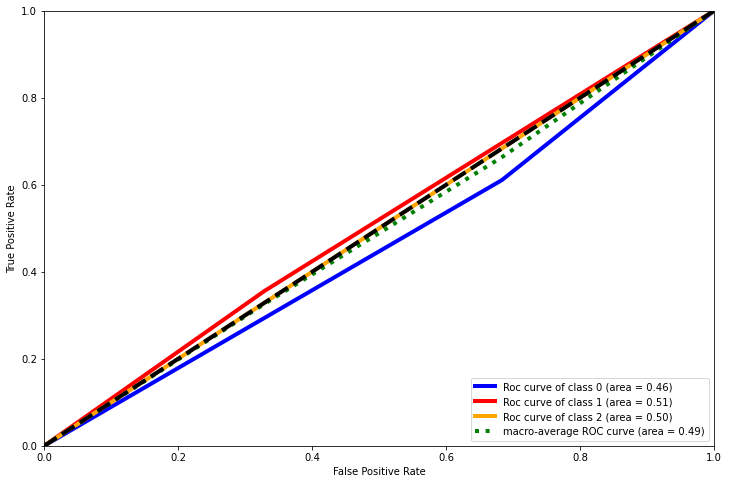

In [94]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=1000, random_state=0)
mlp.fit(X_train, y_train)
# Predicting the Test set results
y_pred = mlp.predict(X_test)
macro_avg_mlp = plot(y_test,y_pred)

In [95]:
cv = KFold(n_splits=5, random_state=0,shuffle=True)
lb = LabelBinarizer()
y_train = np.array([number[0] for number in lb.fit_transform(y_train)])

#use k-fold CV to evaluate model
score_acc_mlp = cross_val_score(mlp, X_train, y_train, scoring='accuracy',
                         cv=cv, n_jobs=-1)

score_recall_mlp = cross_val_score(mlp, X_train, y_train, scoring='recall_macro',
                         cv=cv, n_jobs=-1)

score_precision_mlp = cross_val_score(mlp, X_train, y_train, scoring='precision_weighted',
                         cv=cv, n_jobs=-1)

score_f_mlp = cross_val_score(mlp, X_train, y_train, scoring='f1_macro',
                         cv=cv, n_jobs=-1)

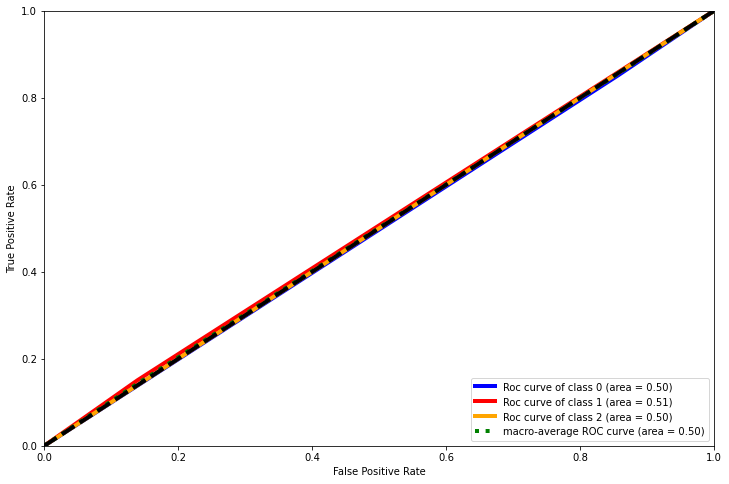

In [96]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

# Create a dictionary of all values we want to test for n_neighbors
params_knn = {'n_neighbors': np.arange(1, 3)}

# Use gridsearch to test all values for n_neighbors
knn_gs = GridSearchCV(knn, params_knn, cv=5)
knn_gs.fit(X_train, y_train)
knn_best = knn_gs.best_estimator_
y_pred = knn_best.predict(X_test)

macro_avg_knn = plot(y_test,y_pred)

In [97]:
cv = KFold(n_splits=5, random_state=0,shuffle=True)
lb = LabelBinarizer()
y_train = np.array([number[0] for number in lb.fit_transform(y_train)])

#use k-fold CV to evaluate model
score_acc_knn = cross_val_score(knn_best, X_train, y_train, scoring='accuracy',
                         cv=cv, n_jobs=-1)

score_recall_knn = cross_val_score(knn_best, X_train, y_train, scoring='recall_macro',
                         cv=cv, n_jobs=-1)

score_precision_knn = cross_val_score(knn_best, X_train, y_train, scoring='precision_weighted',
                         cv=cv, n_jobs=-1)

score_f_knn = cross_val_score(knn_best, X_train, y_train, scoring='f1_macro',
                         cv=cv, n_jobs=-1)


In [98]:
print('sum of score in DJI 4 years ago')
print('accuracy')
print('DecisionTree ',np.mean(score_acc_dtc))
print('RandomForest ',np.mean(score_acc_rf))
print('MLP          ',np.mean(score_acc_mlp))
print('KNeighbors   ',np.mean(score_acc_knn))

print('\nrecall')
print('DecisionTree ',np.mean(score_recall_dtc))
print('RandomForest ',np.mean(score_recall_rf))
print('MLP          ',np.mean(score_recall_mlp))
print('KNeighbors   ',np.mean(score_recall_knn))

print('\nprecision')
print('DecisionTree ',np.mean(score_precision_dtc))
print('RandomForest ',np.mean(score_precision_rf))
print('MLP          ',np.mean(score_precision_mlp))
print('KNeighbors   ',np.mean(score_precision_knn))

print('\nf-socre')
print('DecisionTree ',np.mean(score_f_dtc))
print('RandomForest ',np.mean(score_f_rf))
print('MLP          ',np.mean(score_f_mlp))
print('KNeighbors   ',np.mean(score_f_knn))

print('\nROC CURVE macro average ')
print('DecisionTree ',macro_avg_dtc)
print('RandomForest ',macro_avg_rf)
print('MLP          ', macro_avg_mlp)
print('KNeighbors   ',macro_avg_knn)

sum of score in DJI 4 years ago
accuracy
DecisionTree  0.5561335509315926
RandomForest  0.6284645722834218
MLP           0.6168094655242757
KNeighbors    0.6378348973208214

recall
DecisionTree  0.5115524695887761
RandomForest  0.5327606056228393
MLP           0.5522484902067063
KNeighbors    0.5296126588852119

precision
DecisionTree  0.5550156181517623
RandomForest  0.5878037708382029
MLP           0.5983297310788045
KNeighbors    0.593686276526093

f-socre
DecisionTree  0.5110084427301667
RandomForest  0.5148412697856116
MLP           0.5490978051758308
KNeighbors    0.4992776034528565

ROC CURVE macro average 
DecisionTree  0.5458561930985504
RandomForest  0.48820864299325495
MLP           0.49241468353906115
KNeighbors    0.5010255699811217


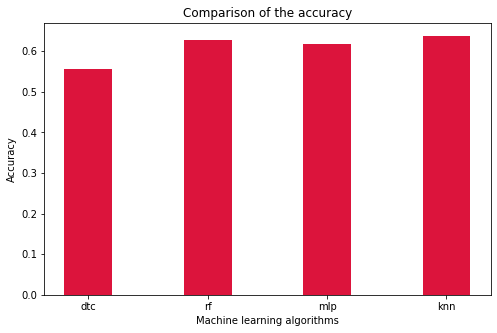

In [99]:
data = {'dtc':np.mean(score_acc_dtc), 'rf':np.mean(score_acc_rf), 'mlp':np.mean(score_acc_mlp),'knn':np.mean(score_acc_knn)}

courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (8, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='crimson',
        width = 0.4)
 
plt.xlabel("Machine learning algorithms")
plt.ylabel("Accuracy")
plt.title("Comparison of the accuracy")
plt.show()

SSE composite index ของ Shanghai 2 years ago

In [100]:
symbol = '000001.SS'
data = yf.download(symbol, start='2019-12-04', end='2021-12-04', interval=INTERVAL) #2 ปี
data = get_indicator(data)

data['pred'] = 0
data = pred(data,1)

data = data.fillna(method='bfill') # Some indicators produce NaN values for the first few rows, we just remove them here
data.dropna(inplace=True)
del (data['Close'])
X = data.drop("pred", axis=1)  # Feature Matrix
y = data["pred"] 

#feature selection
nof = feature_selection(X,y)

y = y.astype('int')
cols = list(X.columns)
model = RandomForestClassifier(random_state=0)
rfe = RFE(model, n_features_to_select=nof)             
X_rfe = rfe.fit_transform(X,y)  
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_, index = cols)
selected_features_rfe = temp[temp==True].index

print(selected_features_rfe)

#data after feature selection
feats = data[selected_features_rfe] # Feature Matrix
X = feats
y = data["pred"] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.15, random_state=0)

# Feature Scale
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

[*********************100%***********************]  1 of 1 completed
Optimum number of features: 7
Score with 7 features: 0.808219
Index(['14 period ATR', 'ROC', '20 period CCI', 'VIp', 'ema15', 'ema5',
       'normVol'],
      dtype='object')


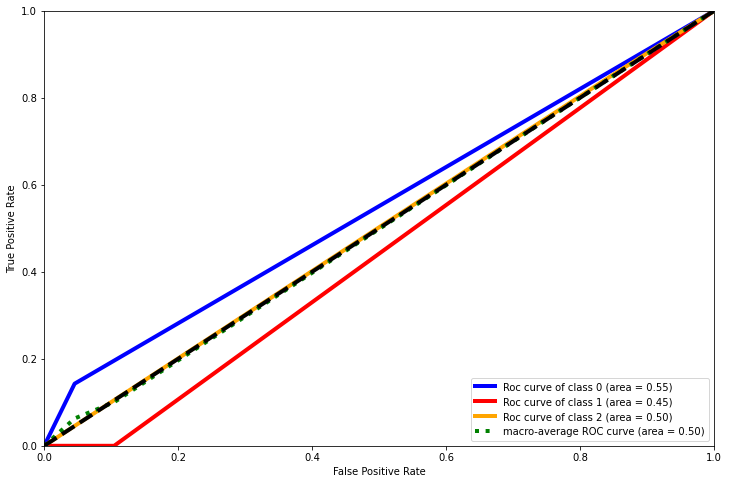

In [101]:
dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(X_train, y_train)

# Prediction
y_pred = dtc.predict(X_test)
macro_avg_dtc = plot(y_test,y_pred)

In [102]:
cv = KFold(n_splits=5, random_state=0,shuffle=True)
lb = LabelBinarizer()
y_train = np.array([number[0] for number in lb.fit_transform(y_train)])

#use k-fold CV to evaluate model
score_acc_dtc = cross_val_score(dtc, X_train, y_train, scoring='accuracy',
                         cv=cv, n_jobs=-1)

score_recall_dtc = cross_val_score(dtc, X_train, y_train, scoring='recall_macro',
                         cv=cv, n_jobs=-1)

score_precision_dtc = cross_val_score(dtc, X_train, y_train, scoring='precision_weighted',
                         cv=cv, n_jobs=-1)

score_f_dtc = cross_val_score(dtc, X_train, y_train, scoring='f1_macro',
                         cv=cv, n_jobs=-1)

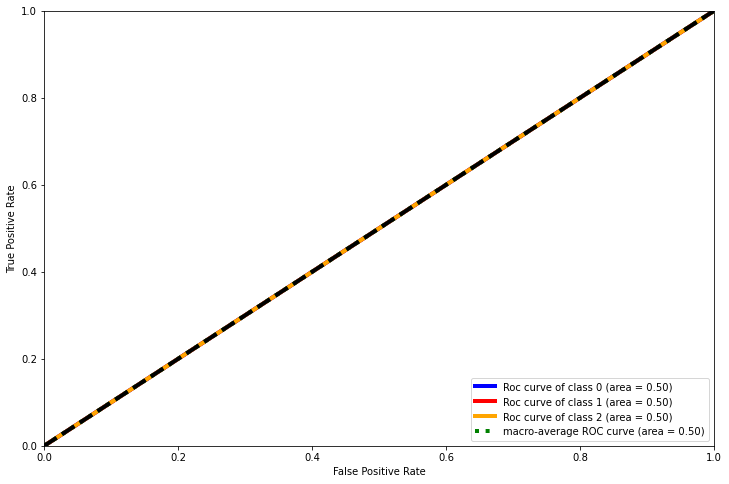

In [103]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)
# Predicting the Test set results
y_pred = rf.predict(X_test)
macro_avg_rf = plot(y_test,y_pred)

In [104]:
cv = KFold(n_splits=5, random_state=0,shuffle=True)
lb = LabelBinarizer()
y_train = np.array([number[0] for number in lb.fit_transform(y_train)])

#use k-fold CV to evaluate model
score_acc_rf = cross_val_score(rf, X_train, y_train, scoring='accuracy',
                         cv=cv, n_jobs=-1)

score_recall_rf = cross_val_score(rf, X_train, y_train, scoring='recall_macro',
                         cv=cv, n_jobs=-1)

score_precision_rf = cross_val_score(rf, X_train, y_train, scoring='precision_weighted',
                         cv=cv, n_jobs=-1)

score_f_rf = cross_val_score(rf, X_train, y_train, scoring='f1_macro',
                         cv=cv, n_jobs=-1)

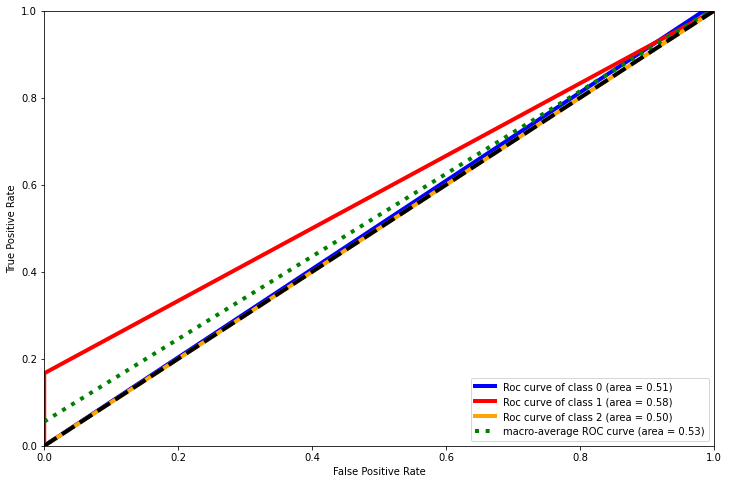

In [105]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=1000, random_state=0)
mlp.fit(X_train, y_train)
# Predicting the Test set results
y_pred = mlp.predict(X_test)
macro_avg_mlp = plot(y_test,y_pred)

In [106]:
cv = KFold(n_splits=5, random_state=0,shuffle=True)
lb = LabelBinarizer()
y_train = np.array([number[0] for number in lb.fit_transform(y_train)])

#use k-fold CV to evaluate model
score_acc_mlp = cross_val_score(mlp, X_train, y_train, scoring='accuracy',
                         cv=cv, n_jobs=-1)

score_recall_mlp = cross_val_score(mlp, X_train, y_train, scoring='recall_macro',
                         cv=cv, n_jobs=-1)

score_precision_mlp = cross_val_score(mlp, X_train, y_train, scoring='precision_weighted',
                         cv=cv, n_jobs=-1)

score_f_mlp = cross_val_score(mlp, X_train, y_train, scoring='f1_macro',
                         cv=cv, n_jobs=-1)

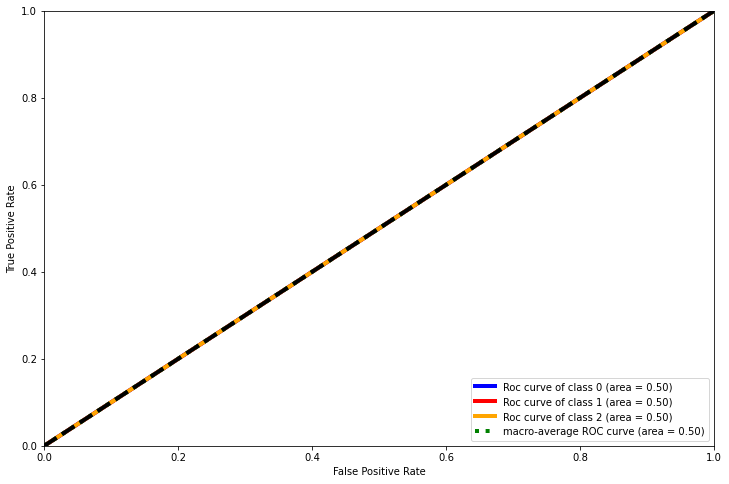

In [107]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

# Create a dictionary of all values we want to test for n_neighbors
params_knn = {'n_neighbors': np.arange(1, 3)}

# Use gridsearch to test all values for n_neighbors
knn_gs = GridSearchCV(knn, params_knn, cv=5)
knn_gs.fit(X_train, y_train)
knn_best = knn_gs.best_estimator_
y_pred = knn_best.predict(X_test)

macro_avg_knn = plot(y_test,y_pred)

In [108]:
cv = KFold(n_splits=5, random_state=0,shuffle=True)
lb = LabelBinarizer()
y_train = np.array([number[0] for number in lb.fit_transform(y_train)])

#use k-fold CV to evaluate model
score_acc_knn = cross_val_score(knn_best, X_train, y_train, scoring='accuracy',
                         cv=cv, n_jobs=-1)

score_recall_knn = cross_val_score(knn_best, X_train, y_train, scoring='recall_macro',
                         cv=cv, n_jobs=-1)

score_precision_knn = cross_val_score(knn_best, X_train, y_train, scoring='precision_weighted',
                         cv=cv, n_jobs=-1)

score_f_knn = cross_val_score(knn_best, X_train, y_train, scoring='f1_macro',
                         cv=cv, n_jobs=-1)

In [109]:
print('sum of score in SSE 2 years ago')
print('accuracy')
print('DecisionTree ',np.mean(score_acc_dtc))
print('RandomForest ',np.mean(score_acc_rf))
print('MLP          ',np.mean(score_acc_mlp))
print('KNeighbors   ',np.mean(score_acc_knn))

print('\nrecall')
print('DecisionTree ',np.mean(score_recall_dtc))
print('RandomForest ',np.mean(score_recall_rf))
print('MLP          ',np.mean(score_recall_mlp))
print('KNeighbors   ',np.mean(score_recall_knn))

print('\nprecision')
print('DecisionTree ',np.mean(score_precision_dtc))
print('RandomForest ',np.mean(score_precision_rf))
print('MLP          ',np.mean(score_precision_mlp))
print('KNeighbors   ',np.mean(score_precision_knn))

print('\nf-socre')
print('DecisionTree ',np.mean(score_f_dtc))
print('RandomForest ',np.mean(score_f_rf))
print('MLP          ',np.mean(score_f_mlp))
print('KNeighbors   ',np.mean(score_f_knn))

print('\nROC CURVE macro average ')
print('DecisionTree ',macro_avg_dtc)
print('RandomForest ',macro_avg_rf)
print('MLP          ', macro_avg_mlp)
print('KNeighbors   ',macro_avg_knn)

sum of score in SSE 2 years ago
accuracy
DecisionTree  0.8837202468410226
RandomForest  0.934528357331766
MLP           0.9272994416691155
KNeighbors    0.9345577431677932

recall
DecisionTree  0.48342756463809095
RandomForest  0.49743209876543215
MLP           0.5066332926332926
KNeighbors    0.49748338081671417

precision
DecisionTree  0.8850800173464837
RandomForest  0.8825998722241766
MLP           0.8899491529859258
KNeighbors    0.8826545806801814

f-socre
DecisionTree  0.48569214518865544
RandomForest  0.4830226555955949
MLP           0.5010465463265408
KNeighbors    0.4830478520597971

ROC CURVE macro average 
DecisionTree  0.49946185655140884
RandomForest  0.5
MLP           0.5303030303030303
KNeighbors    0.5


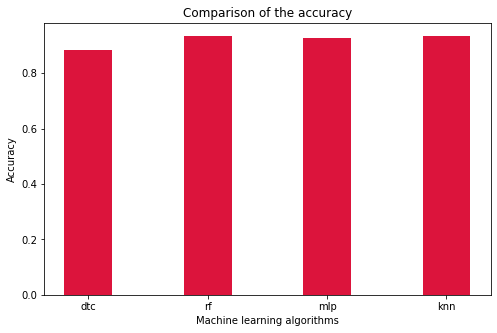

In [110]:
data = {'dtc':np.mean(score_acc_dtc), 'rf':np.mean(score_acc_rf), 'mlp':np.mean(score_acc_mlp),'knn':np.mean(score_acc_knn)}

courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (8, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='crimson',
        width = 0.4)
 
plt.xlabel("Machine learning algorithms")
plt.ylabel("Accuracy")
plt.title("Comparison of the accuracy")
plt.show()

SSE 4 years ago

In [111]:
data = yf.download(symbol, start='2017-12-04', end='2021-12-04', interval=INTERVAL) #4 ปี
data = get_indicator(data)
data['pred'] = 0
data = pred(data,1)

data = data.fillna(method='bfill') # Some indicators produce NaN values for the first few rows, we just remove them here
data.dropna(inplace=True)
del (data['Close'])
X = data.drop("pred", axis=1)  # Feature Matrix
y = data["pred"] 

#feature selection
nof = feature_selection(X,y)

y = y.astype('int')
cols = list(X.columns)
model = RandomForestClassifier(random_state=0)
rfe = RFE(model, n_features_to_select=nof)             
X_rfe = rfe.fit_transform(X,y)  
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_, index = cols)
selected_features_rfe = temp[temp==True].index

print(selected_features_rfe)

#data after feature selection

feats = data[selected_features_rfe] # Feature Matrix
X = feats
y = data["pred"] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.15, random_state=0)

# Feature Scale
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

[*********************100%***********************]  1 of 1 completed
Optimum number of features: 6
Score with 6 features: 0.828767
Index(['MACD', '14 period STOCH %K', '14 period ATR', '14 period EMV', 'ema50',
       'normVol'],
      dtype='object')


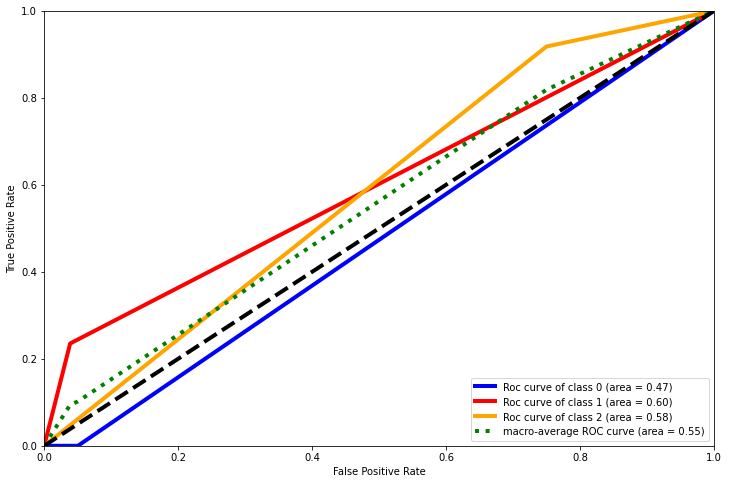

In [112]:
dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(X_train, y_train)

# Prediction
y_pred = dtc.predict(X_test)
macro_avg_dtc = plot(y_test,y_pred)

In [113]:
cv = KFold(n_splits=5, random_state=0,shuffle=True)
lb = LabelBinarizer()
y_train = np.array([number[0] for number in lb.fit_transform(y_train)])

#use k-fold CV to evaluate model
score_acc_dtc = cross_val_score(dtc, X_train, y_train, scoring='accuracy',
                         cv=cv, n_jobs=-1)

score_recall_dtc = cross_val_score(dtc, X_train, y_train, scoring='recall_macro',
                         cv=cv, n_jobs=-1)

score_precision_dtc = cross_val_score(dtc, X_train, y_train, scoring='precision_weighted',
                         cv=cv, n_jobs=-1)

score_f_dtc = cross_val_score(dtc, X_train, y_train, scoring='f1_macro',
                         cv=cv, n_jobs=-1)



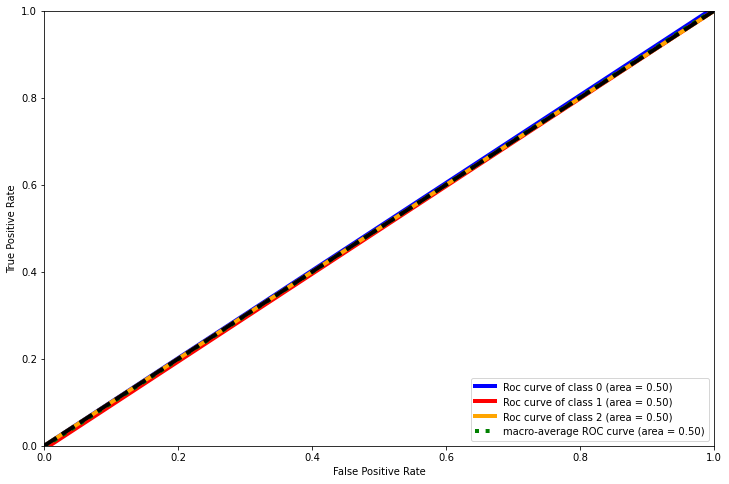

In [114]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)
# Predicting the Test set results
y_pred = rf.predict(X_test)
macro_avg_rf = plot(y_test,y_pred)

In [115]:
cv = KFold(n_splits=5, random_state=0,shuffle=True)
lb = LabelBinarizer()
y_train = np.array([number[0] for number in lb.fit_transform(y_train)])

#use k-fold CV to evaluate model
score_acc_rf = cross_val_score(rf, X_train, y_train, scoring='accuracy',
                         cv=cv, n_jobs=-1)

score_recall_rf = cross_val_score(rf, X_train, y_train, scoring='recall_macro',
                         cv=cv, n_jobs=-1)

score_precision_rf = cross_val_score(rf, X_train, y_train, scoring='precision_weighted',
                         cv=cv, n_jobs=-1)

score_f_rf = cross_val_score(rf, X_train, y_train, scoring='f1_macro',
                         cv=cv, n_jobs=-1)


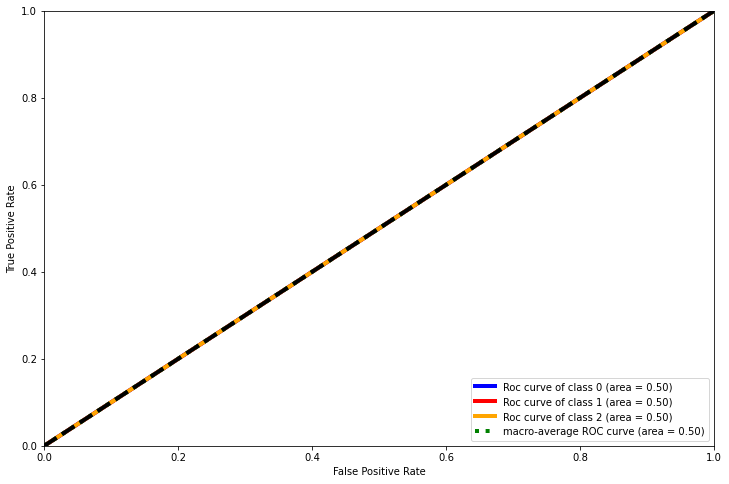

In [116]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=1000, random_state=0)
mlp.fit(X_train, y_train)
# Predicting the Test set results
y_pred = mlp.predict(X_test)
macro_avg_mlp = plot(y_test,y_pred)

In [117]:
cv = KFold(n_splits=5, random_state=0,shuffle=True)
lb = LabelBinarizer()
y_train = np.array([number[0] for number in lb.fit_transform(y_train)])

#use k-fold CV to evaluate model
score_acc_mlp = cross_val_score(mlp, X_train, y_train, scoring='accuracy',
                         cv=cv, n_jobs=-1)

score_recall_mlp = cross_val_score(mlp, X_train, y_train, scoring='recall_macro',
                         cv=cv, n_jobs=-1)

score_precision_mlp = cross_val_score(mlp, X_train, y_train, scoring='precision_weighted',
                         cv=cv, n_jobs=-1)

score_f_mlp = cross_val_score(mlp, X_train, y_train, scoring='f1_macro',
                         cv=cv, n_jobs=-1)


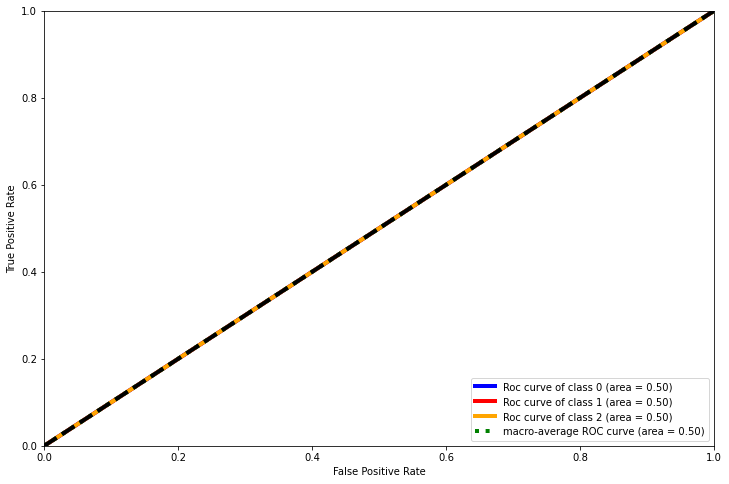

In [118]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

# Create a dictionary of all values we want to test for n_neighbors
params_knn = {'n_neighbors': np.arange(1, 3)}

# Use gridsearch to test all values for n_neighbors
knn_gs = GridSearchCV(knn, params_knn, cv=5)
knn_gs.fit(X_train, y_train)
knn_best = knn_gs.best_estimator_
y_pred = knn_best.predict(X_test)

macro_avg_knn = plot(y_test,y_pred)

In [119]:
cv = KFold(n_splits=5, random_state=0,shuffle=True)
lb = LabelBinarizer()
y_train = np.array([number[0] for number in lb.fit_transform(y_train)])

#use k-fold CV to evaluate model
score_acc_knn = cross_val_score(knn_best, X_train, y_train, scoring='accuracy',
                         cv=cv, n_jobs=-1)

score_recall_knn = cross_val_score(knn_best, X_train, y_train, scoring='recall_macro',
                         cv=cv, n_jobs=-1)

score_precision_knn = cross_val_score(knn_best, X_train, y_train, scoring='precision_weighted',
                         cv=cv, n_jobs=-1)

score_f_knn = cross_val_score(knn_best, X_train, y_train, scoring='f1_macro',
                         cv=cv, n_jobs=-1)


In [120]:
print('sum of score in SSE 4 years ago')
print('accuracy')
print('DecisionTree ',np.mean(score_acc_dtc))
print('RandomForest ',np.mean(score_acc_rf))
print('MLP          ',np.mean(score_acc_mlp))
print('KNeighbors   ',np.mean(score_acc_knn))

print('\nrecall')
print('DecisionTree ',np.mean(score_recall_dtc))
print('RandomForest ',np.mean(score_recall_rf))
print('MLP          ',np.mean(score_recall_mlp))
print('KNeighbors   ',np.mean(score_recall_knn))

print('\nprecision')
print('DecisionTree ',np.mean(score_precision_dtc))
print('RandomForest ',np.mean(score_precision_rf))
print('MLP          ',np.mean(score_precision_mlp))
print('KNeighbors   ',np.mean(score_precision_knn))

print('\nf-socre')
print('DecisionTree ',np.mean(score_f_dtc))
print('RandomForest ',np.mean(score_f_rf))
print('MLP          ',np.mean(score_f_mlp))
print('KNeighbors   ',np.mean(score_f_knn))

print('\nROC CURVE macro average ')
print('DecisionTree ',macro_avg_dtc)
print('RandomForest ',macro_avg_rf)
print('MLP          ', macro_avg_mlp)
print('KNeighbors   ',macro_avg_knn)

sum of score in SSE 4 years ago
accuracy
DecisionTree  0.8836363636363638
RandomForest  0.9345454545454546
MLP           0.9296969696969697
KNeighbors    0.9296969696969697

recall
DecisionTree  0.5061830253820949
RandomForest  0.4987217185330393
MLP           0.49607390911295834
KNeighbors    0.4961191035049029

precision
DecisionTree  0.8812121174646237
RandomForest  0.8780081076843826
MLP           0.8776207628612912
KNeighbors    0.8776960339220741

f-socre
DecisionTree  0.5031867647164776
RandomForest  0.48305970115390073
MLP           0.48172139257060503
KNeighbors    0.4817478167377159

ROC CURVE macro average 
DecisionTree  0.5523679170632679
RandomForest  0.49990705110330347
MLP           0.5
KNeighbors    0.5


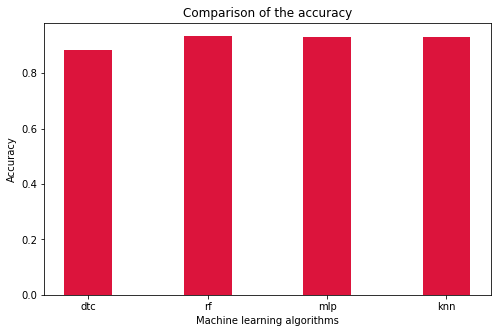

In [121]:
data = {'dtc':np.mean(score_acc_dtc), 'rf':np.mean(score_acc_rf), 'mlp':np.mean(score_acc_mlp),'knn':np.mean(score_acc_knn)}

courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (8, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='crimson',
        width = 0.4)
 
plt.xlabel("Machine learning algorithms")
plt.ylabel("Accuracy")
plt.title("Comparison of the accuracy")
plt.show()